# Set Up

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import seaborn.objects as so

import glob
import os

import math

from scipy import stats

In [2]:
sns.set_theme()
sns.set_palette("Paired")

PATH_TO_LOGS = os.getcwd()+"/logs/"
print(PATH_TO_LOGS)

TIME_BTN_POWER = 0.5

/Users/cjparra/Work/wfey/logs/


# Processing Logs

In [3]:
def removeOutliers(DATA, THRESHHOLD_Z=2, VERBOSE=False):
    
    hwmon2_mean_z  = np.abs(stats.zscore(DATA['hwmon2_mean'], nan_policy='omit'))
    hwmon2_min_z   = np.abs(stats.zscore(DATA['hwmon2_min'], nan_policy='omit'))
    hwmon2_max_z   = np.abs(stats.zscore(DATA['hwmon2_max'], nan_policy='omit'))
    latency_mean_z = np.abs(stats.zscore(DATA['latency_mean'], nan_policy='omit'))
    latency_min_z  = np.abs(stats.zscore(DATA['latency_min'], nan_policy='omit'))
    latency_max_z  = np.abs(stats.zscore(DATA['latency_max'], nan_policy='omit'))

    hwmon2_mean_out = np.where(hwmon2_mean_z > THRESHHOLD_Z)[0]
    hwmon2_min_out = np.where(hwmon2_min_z > THRESHHOLD_Z)[0]
    hwmon2_max_out = np.where(hwmon2_max_z > THRESHHOLD_Z)[0]
    latency_mean_out = np.where(latency_mean_z > THRESHHOLD_Z)[0]
    latency_min_out = np.where(latency_min_z > THRESHHOLD_Z)[0]
    latency_max_out = np.where(latency_max_z > THRESHHOLD_Z)[0]

    
    outlier_indices = np.unique(np.concat((hwmon2_mean_out, hwmon2_min_out, hwmon2_max_out, latency_mean_out, latency_min_out, latency_max_out)))
    no_outliers = DATA.drop(outlier_indices)

    if (VERBOSE):
        
        print("Original DataFrame Shape:", DATA.shape)
        print("DataFrame Shape after Removing Outliers:", no_outliers.shape)
        print("Removed Indexes:")
        print(outlier_indices)
        print("\t HWMON -- mean, min, max")
        print(DATA.loc[hwmon2_mean_out, ['KEY', 'hwmon2_mean']])
        print(DATA.loc[hwmon2_min_out, ['KEY', 'hwmon2_min']])
        print(DATA.loc[hwmon2_max_out, ['KEY', 'hwmon2_max']])
        print("\t Latency -- mean, min, max")
        print(DATA.loc[latency_mean_out, ['KEY', 'latency_mean']])
        print(DATA.loc[latency_min_out, ['KEY', 'latency_min']])
        print(DATA.loc[latency_max_out, ['KEY', 'latency_max']])
    
    return no_outliers.reset_index(drop=True)

In [4]:
CONFIGS=["busypoll_nodb_wfey", "busypoll_db_wfey", "wfe_nodb_wfey", "wfe_db_nomon_wfey", "wfe_db_mon_wfey" ]
NUMEVENTS=[10, 50, 100, 1000, 10000, 100000]
EVENTPROCCPUS=[ "1" ]
SLEEPTIME=[ "0.001", "0.01", "0.1", "1" ]
SOURCECPUS=[1, 5, 10, 50, 79]

arr = []
data = []

percent=50

# If RAW=True this means that the entire run's hwmon data will be used, if false only the middle 68% will be used

def processData(CONFIGS, NUMEVENTS, EVENTPROCCPUS, SLEEPTIME, SOURCESCPUS, RAW=True, VERBOSE=False):
    for C in CONFIGS:
        for EVENTS in NUMEVENTS:
            for EVENTCPU in EVENTPROCCPUS:
                for SLEEP in SLEEPTIME:
                    for SOURCECPU in SOURCECPUS:
                        SCPUs=str(SOURCECPU).replace(" ", "_")

                        KEY=C+"/"+str(EVENTS)+"_"+EVENTCPU+"_"+SLEEP+"_"+SCPUs
                        FILE=PATH_TO_LOGS+KEY+"/"
                        HWMONFILE=glob.glob(FILE+'hwmon-*.out')

                        # If no files found with these args -- skip
                        if not HWMONFILE:
                            continue
                            
                        ### For every run of this set of parameters concat
                        hwmonoutput=None
                        latencyoutput=None

                        for runs in HWMONFILE:
                            if os.path.exists(runs):
                                if VERBOSE:
                                    print("processsing:" + runs)

                                try:
                                    df=pd.read_csv(runs, sep=' ')
                                except:
                                    print("Problem parsing hwmon numbers for ", runs)
                                    continue

                                hwmonoutput = pd.concat([hwmonoutput, df])

                                ## --- Grabbing Latency Numbers --- ##
                                latency_file = runs.replace("hwmon", "latency")

                                if os.path.exists(latency_file):
                                    if VERBOSE:
                                        print("processsing:" + latency_file)

                                    try:
                                        latency_df = pd.read_csv(latency_file)
                                    except:
                                        print("Problem parsing latency numbers for ", latency_file)
                                        continue

                                    latencyoutput = pd.concat([latencyoutput, latency_df])
                       
                        if (hwmonoutput is None) or (latencyoutput is None):
                            continue

                        ## --- Find the mean of all runs --- ##
                        by_row_index = hwmonoutput.groupby(hwmonoutput.index)
                        raw_result=by_row_index.mean()

                        ## --- Raw Data or Middle Data --- ##
                        results = raw_result
                        if (not RAW):
                            adj_index = round(len(raw_result)*(percent/100))

                            middle_point = round(len(raw_result)/2)

                            low_index = middle_point-(math.floor(adj_index/2))
                            high_index = middle_point + (math.floor(adj_index/2))

                            results = raw_result[low_index : high_index+1]
     
                        ## --- Find Means of Latencys --- ###
                        ### This means that the individual data for the sources is not saved 
                        ### But I believe that's fine bc we don't care about the about the data
                        ### at the cpu scale but the number of cpu handling the workload
                        
                        latency_results=latencyoutput.drop("ID", axis=1)

                        latency_min = latency_results.loc[:,"Min"].to_numpy()
                        latency_max = latency_results.loc[:,"Max"].to_numpy()
                        latency_mean = latency_results.loc[:,"Mean"].to_numpy()

                        latency_min = stats.gmean(latency_min)
                        latency_max = stats.gmean(latency_max)
                        latency_mean = stats.gmean(latency_mean)

                        ## --- Getting time for every power number -- #
                        
                        runningtime = len(results.index) * TIME_BTN_POWER
                        
                        time_range = np.arange(0, runningtime, TIME_BTN_POWER)
                        #print(time_range)
                        
                        ## --- Making array out of hwmon output --- ##
                        hwmon2_pwr = results.loc[:,"hwmon2"].to_numpy()
                        hwmon3_pwr = results.loc[:,"hwmon3"].to_numpy()

                        ## --- Processing HWMON Numbers --- ## 
                        hwmon2_min = hwmon2_pwr.min()
                        hwmon3_min = hwmon3_pwr.min()

                        hwmon2_max = hwmon2_pwr.max()
                        hwmon3_max = hwmon3_pwr.max()

                        hwmon2_mean = stats.gmean(hwmon2_pwr)
                        hwmon3_mean = stats.gmean(hwmon3_pwr)

                        ## --- Adding data to list --- ##
                        
                        arr.append((C,EVENTS,SLEEP,EVENTCPU,SCPUs,hwmon2_pwr,hwmon3_pwr, hwmon2_min, hwmon2_max, hwmon2_mean, hwmon3_min, hwmon3_max, hwmon3_mean, time_range, latency_min, latency_max, latency_mean, KEY))

    df = pd.DataFrame(data=arr, columns=[ "configs", "numevents", "sleeptime", "eventprocCPUs", "sourceCPUs", "hwmon2", "hwmon3", "hwmon2_min", "hwmon2_max", "hwmon2_mean", "hwmon3_min", "hwmon3_max", "hwmon3_mean", "time", "latency_min", "latency_max", "latency_mean", "KEY"])
    return df

## --- End of processData() --- ##

wfey_output = processData(CONFIGS, NUMEVENTS, EVENTPROCCPUS, SLEEPTIME, SOURCECPUS, RAW=False, VERBOSE=False)
#print(wfey_output)

wfey_no_out_first = removeOutliers(wfey_output, VERBOSE=True)
wfey_no_out = removeOutliers(wfey_no_out_first, VERBOSE=True)
#print(wfey_no_out)


flat_data = wfey_output.explode(["hwmon2","hwmon3","time"], ignore_index=True)
#print(flat_data)


Problem parsing latency numbers for  /Users/cjparra/Work/wfey/logs/busypoll_db_wfey/10_1_0.001_10/latency-2025-07-08-17-54-43.out
Problem parsing latency numbers for  /Users/cjparra/Work/wfey/logs/busypoll_db_wfey/10_1_0.001_10/latency-2025-07-08-15-45-54.out
Problem parsing latency numbers for  /Users/cjparra/Work/wfey/logs/busypoll_db_wfey/1000_1_0.001_5/latency-2025-07-08-15-47-03.out
Problem parsing latency numbers for  /Users/cjparra/Work/wfey/logs/wfe_db_mon_wfey/100_1_0.001_10/latency-2025-07-08-18-07-21.out
Original DataFrame Shape: (235, 18)
DataFrame Shape after Removing Outliers: (211, 18)
Removed Indexes:
[  2   3   4  17  36  37  43  83  84  90  97  98 111 130 131 133 137 158
 177 178 184 224 225 231]
	 HWMON -- mean, min, max
                                 KEY   hwmon2_mean
36   busypoll_nodb_wfey/1000_1_0.1_1  7.800624e+07
37   busypoll_nodb_wfey/1000_1_0.1_5  7.844642e+07
83     busypoll_db_wfey/1000_1_0.1_1  7.810342e+07
84     busypoll_db_wfey/1000_1_0.1_5  7.825032

# Graphs

## Heat Map

<Axes: >

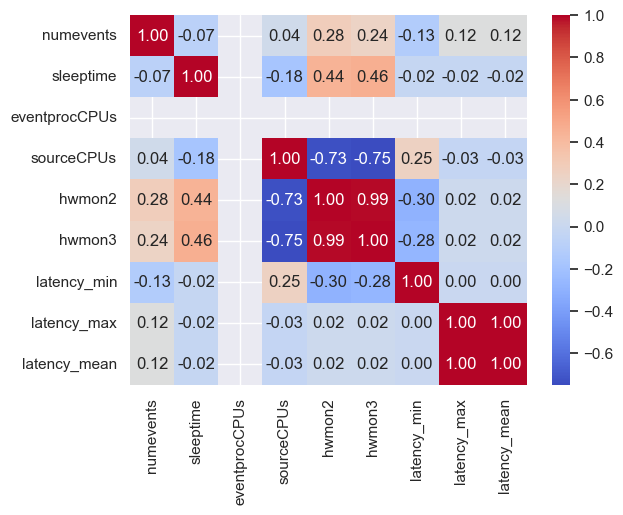

In [5]:
#sns.pairplot(data=flat_data, hue="configs")
corr = flat_data[['numevents', 'sleeptime', 'eventprocCPUs', 'sourceCPUs', 'hwmon2', 'hwmon3', 'latency_min', 'latency_max', 'latency_mean']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')

## Correlations with the HW Monitor Numbers

### HWMON2

#### Choosing subsets of plots

In [6]:
#eventsubset=[100, 1000, 10000]
eventsubset=[1000, 10000]
sleeptimesubset=["0.01","0.001"]
sourceCPUsubset=["10", "50", "79"]

sns.set_palette("Paired")
pd.options.mode.chained_assignment = None

#### Power Graphs

##### Average Power Numbers across all arg configs for each wfey Config

##### Power values over time -- Differentiated by NumEvents

/var/folders/_g/p1k71chj0gz6j8jb7c48r03c0000gn/T/ipykernel_43358/2836286691.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


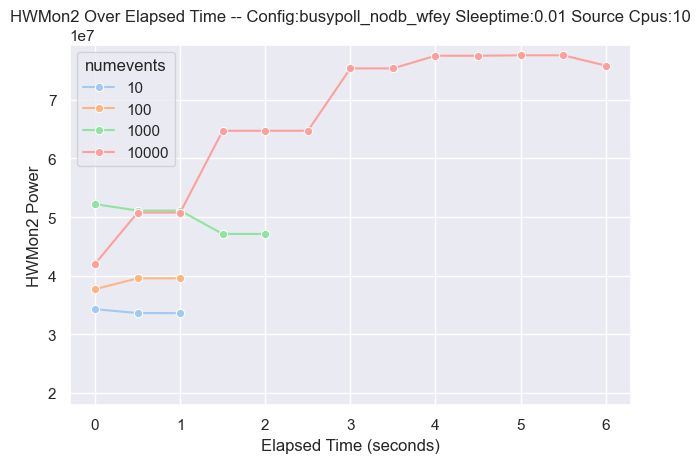

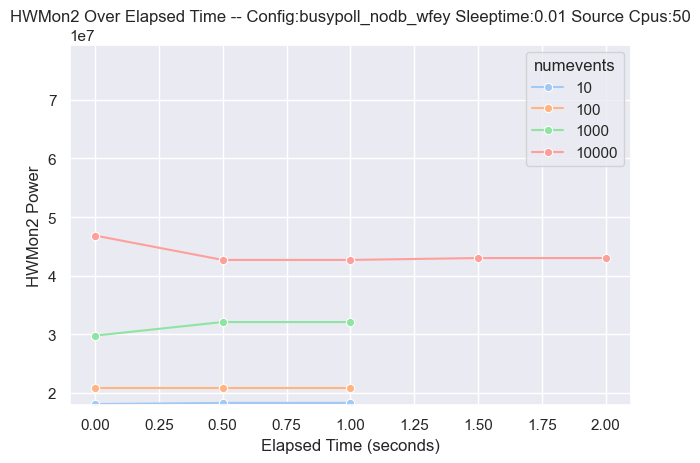

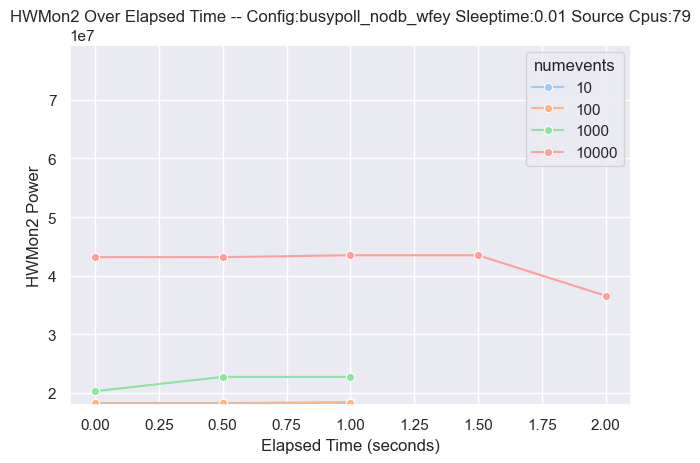

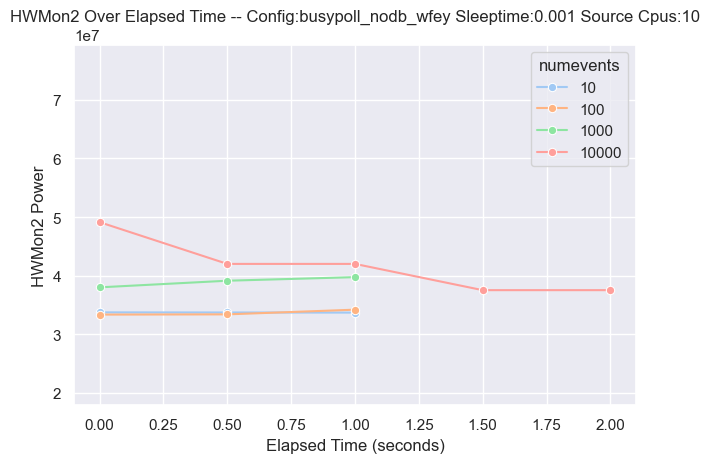

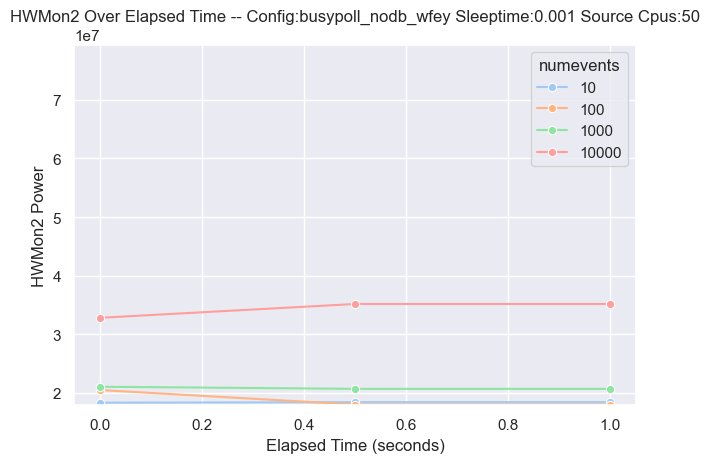

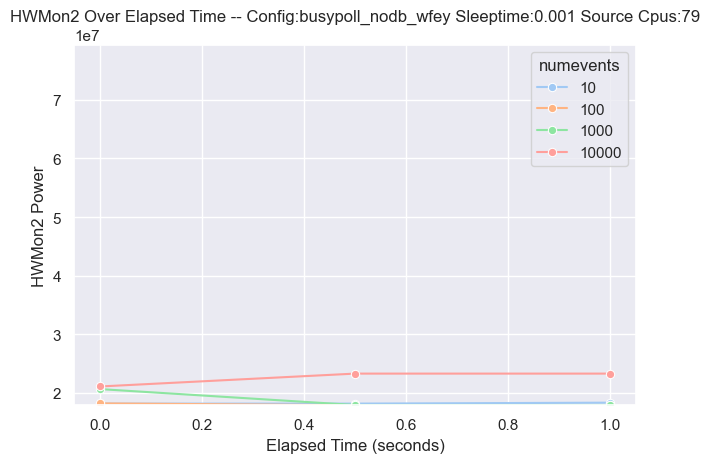

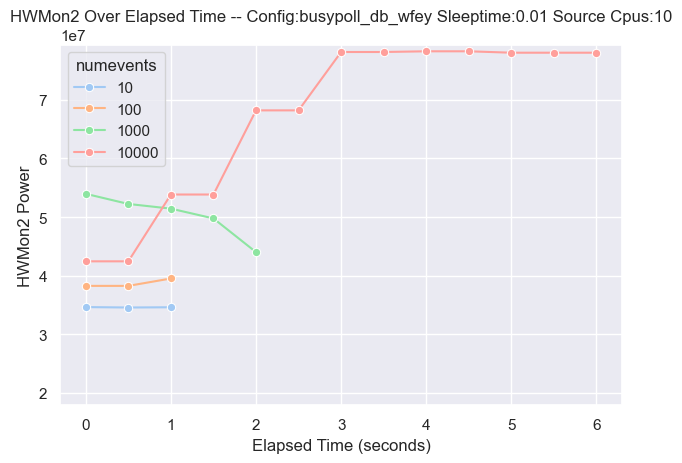

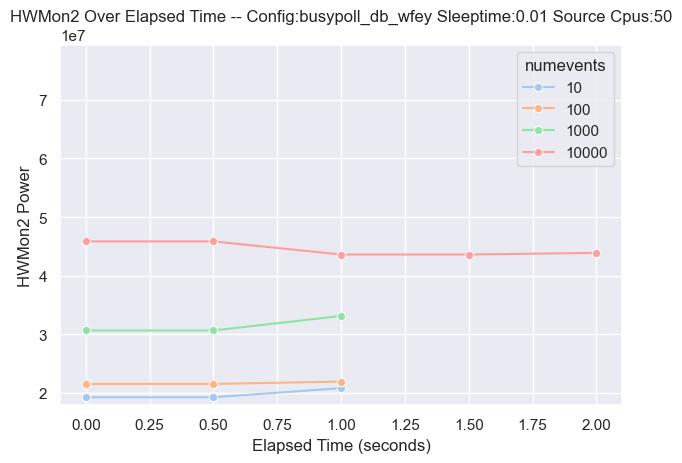

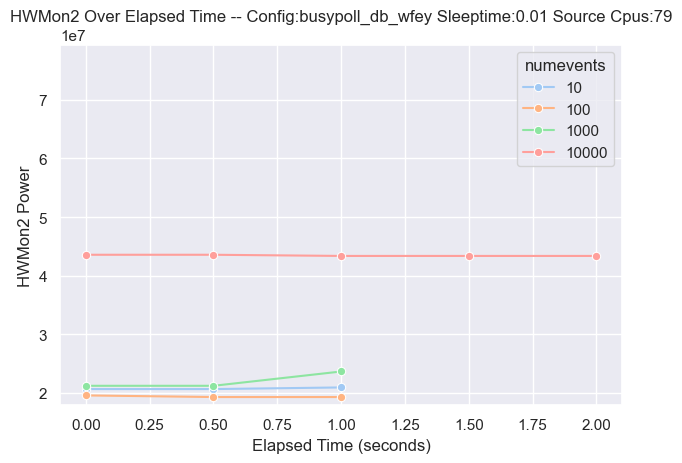

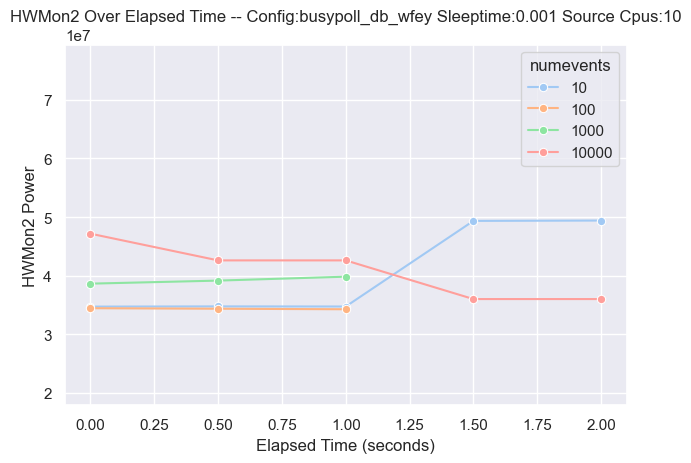

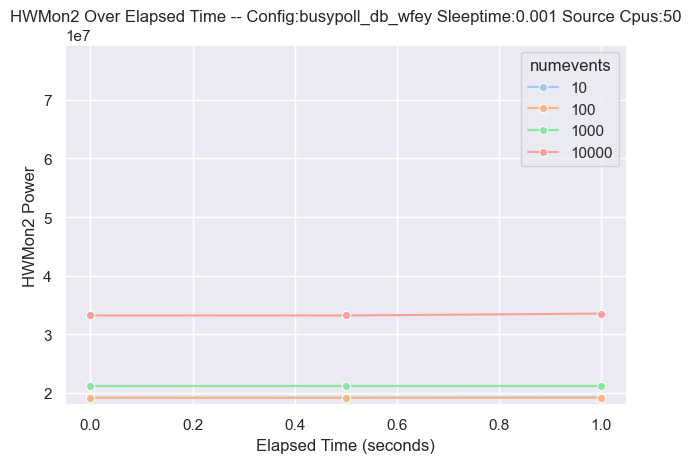

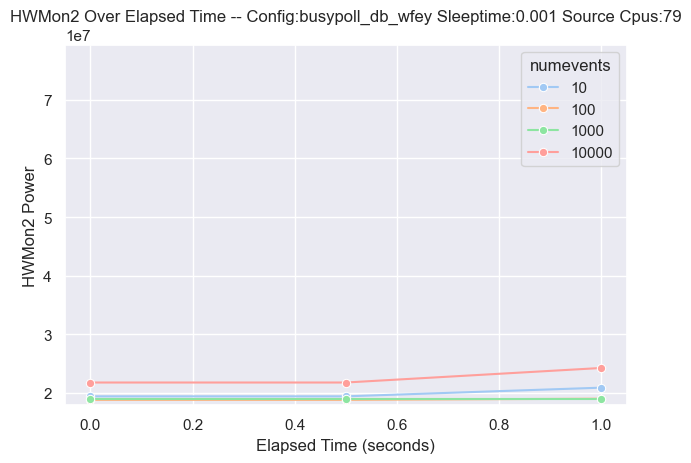

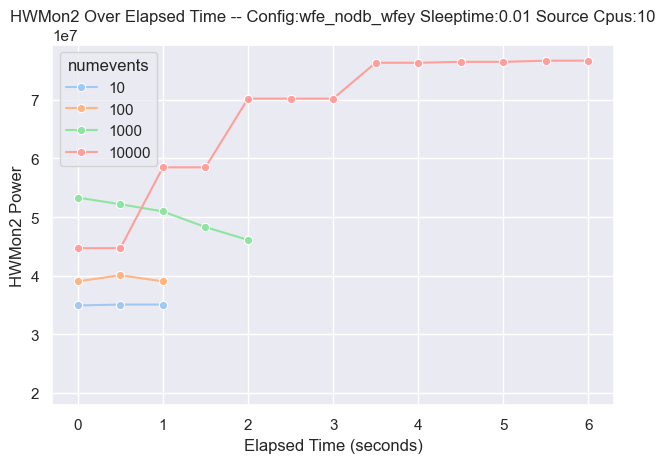

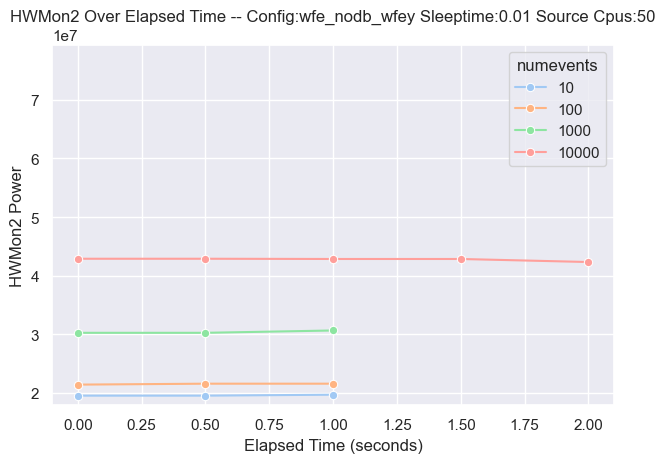

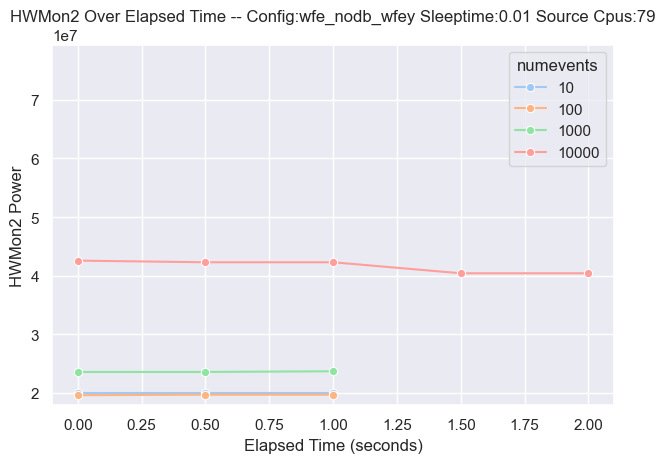

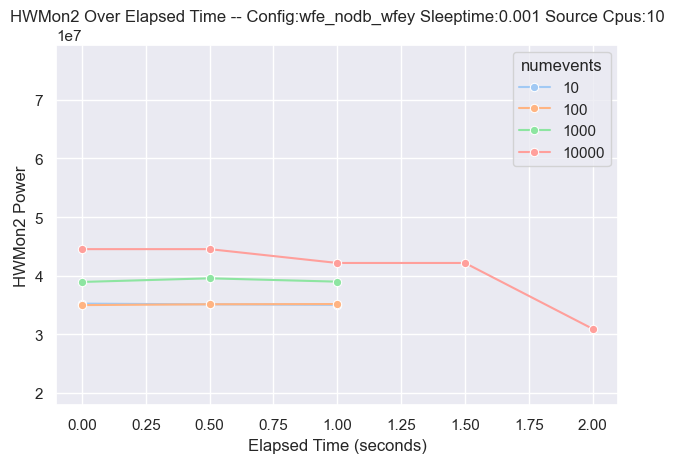

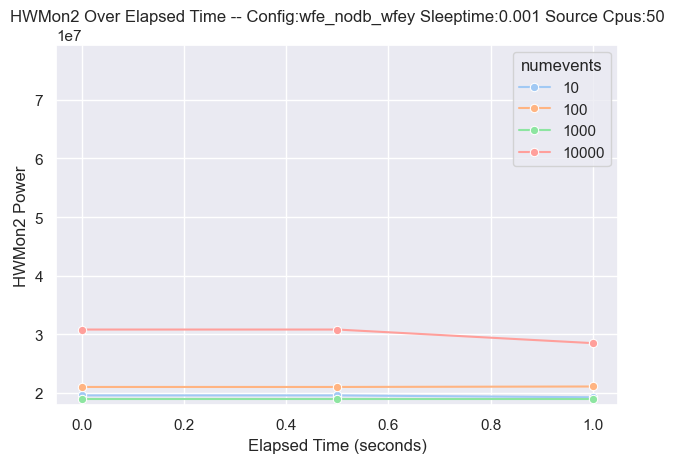

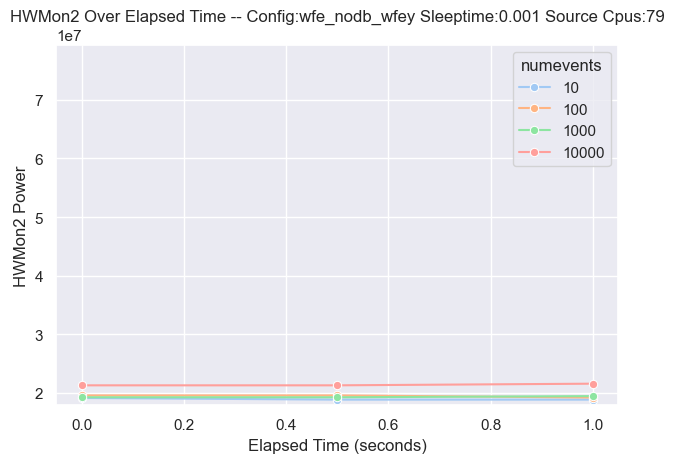

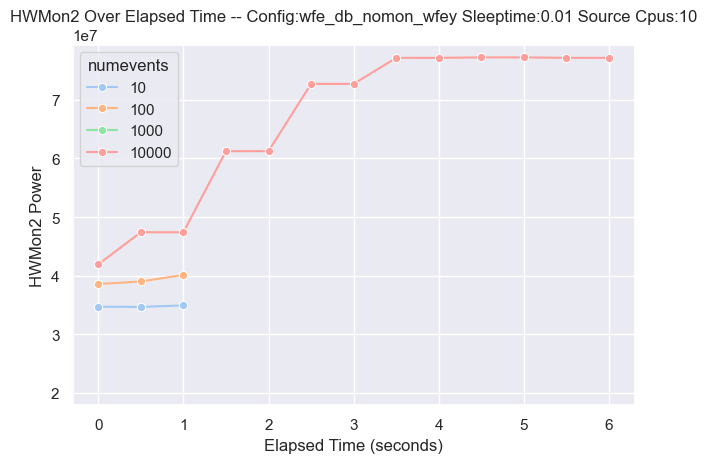

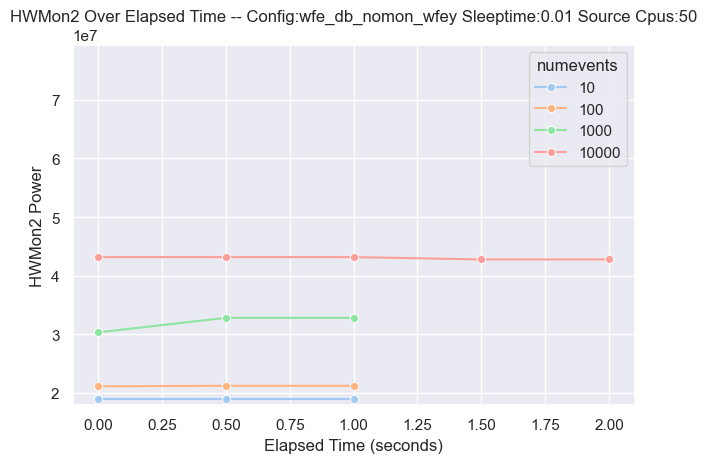

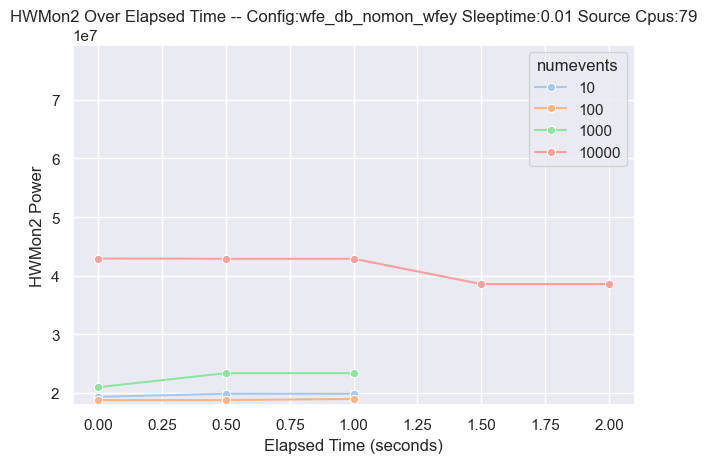

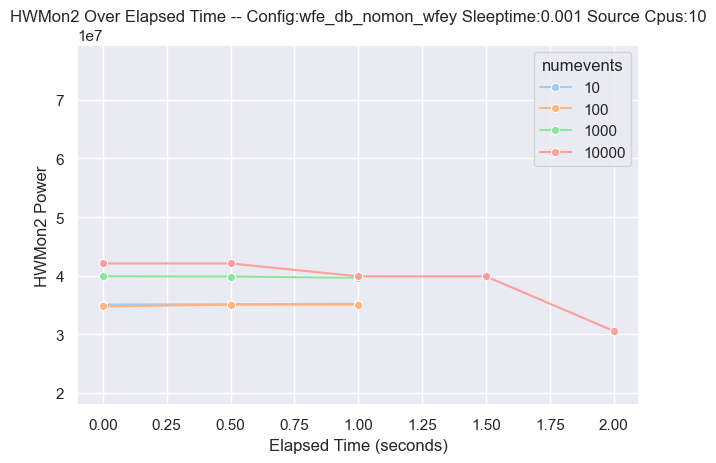

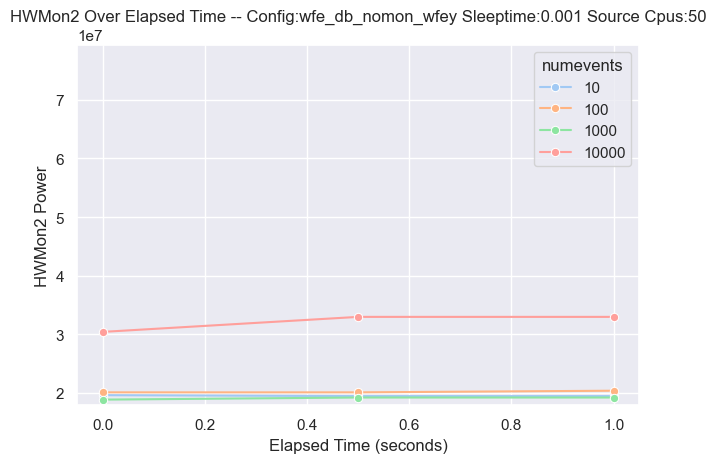

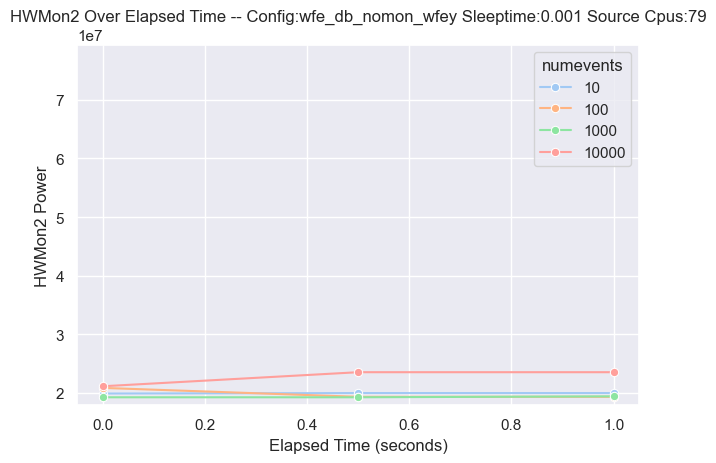

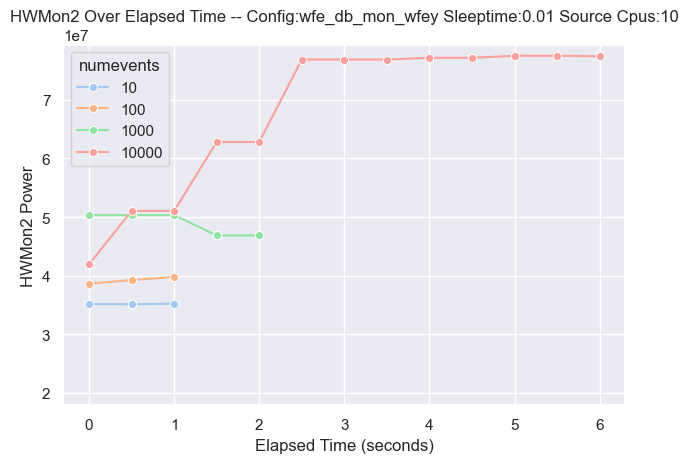

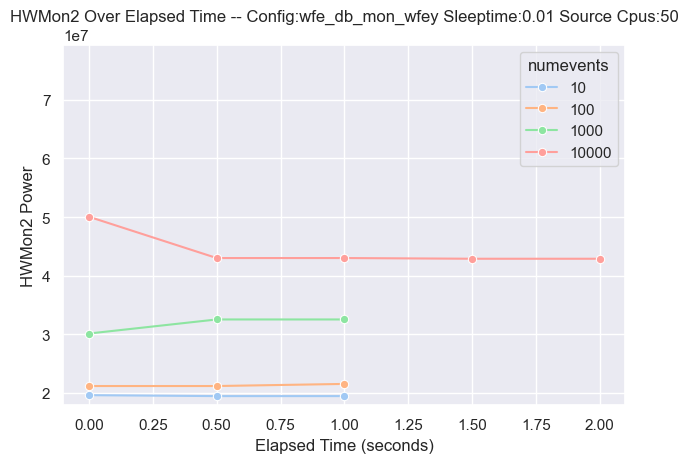

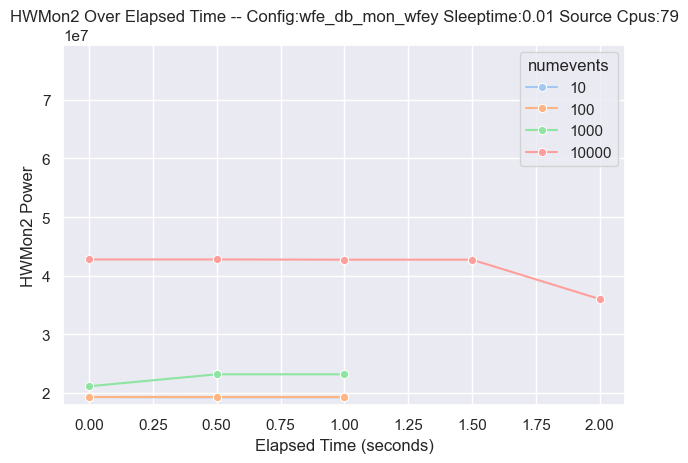

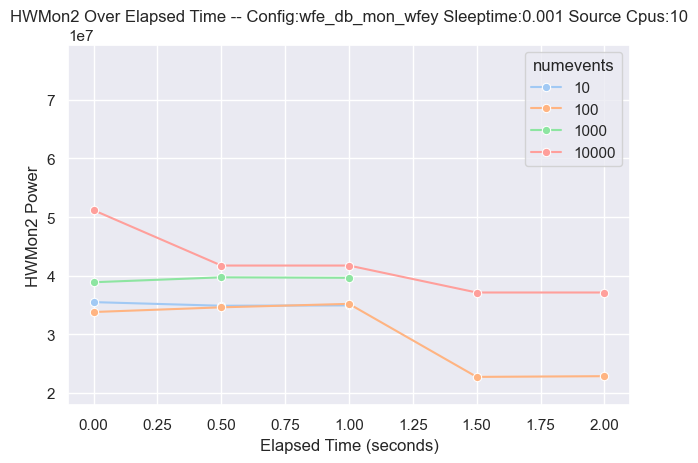

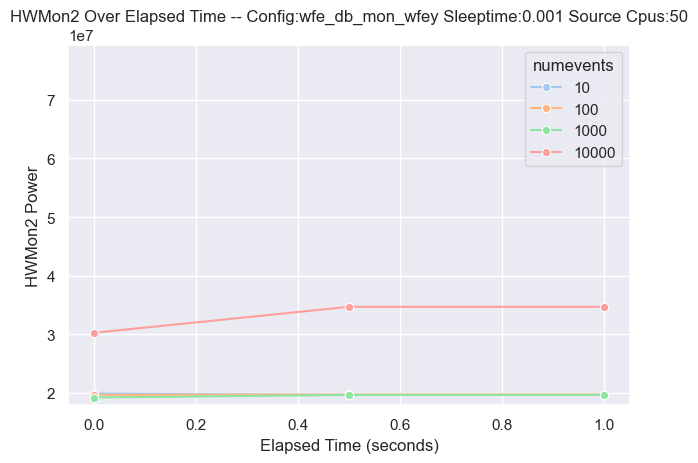

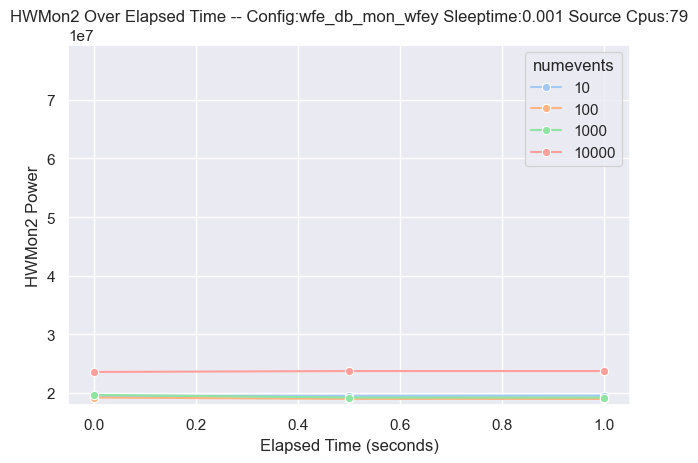

In [7]:
for c in CONFIGS:
    for s in sleeptimesubset:
        for sc in sourceCPUsubset:
            plt.figure()
            config_set = flat_data[ (flat_data['configs'] == c) &
                                    (flat_data['sleeptime'] == s) &
                                    (flat_data['sourceCPUs'] == sc)]
            #print(config_set)
            sns.lineplot(
                data=config_set, 
                x='time',
                y='hwmon2',
                hue='numevents',
                palette='pastel',
                marker='o',        # Adds markers at each point
                errorbar=None
            )
            
            plt.title('HWMon2 Over Elapsed Time -- Config:'+c+' Sleeptime:'+s+' Source Cpus:'+sc)
            plt.xlabel('Elapsed Time (seconds)')
            plt.ylabel('HWMon2 Power')
            plt.ylim(flat_data['hwmon2_min'].min(),flat_data['hwmon2_max'].max())
            plt.tight_layout()

##### Power values over time -- Differentiated by NumEvents -- Standarized 

/var/folders/_g/p1k71chj0gz6j8jb7c48r03c0000gn/T/ipykernel_43358/3068924547.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


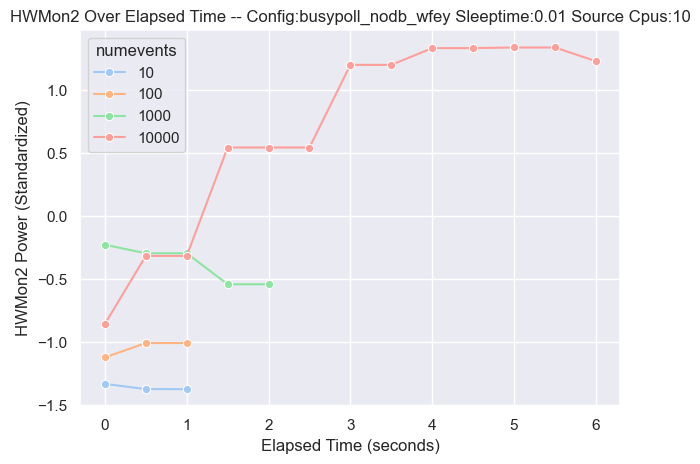

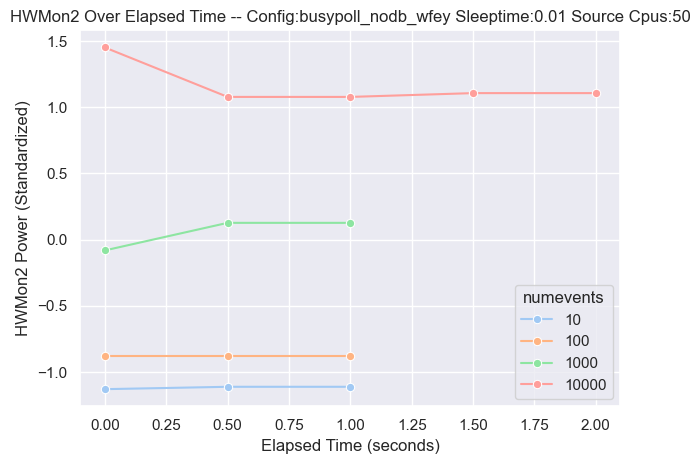

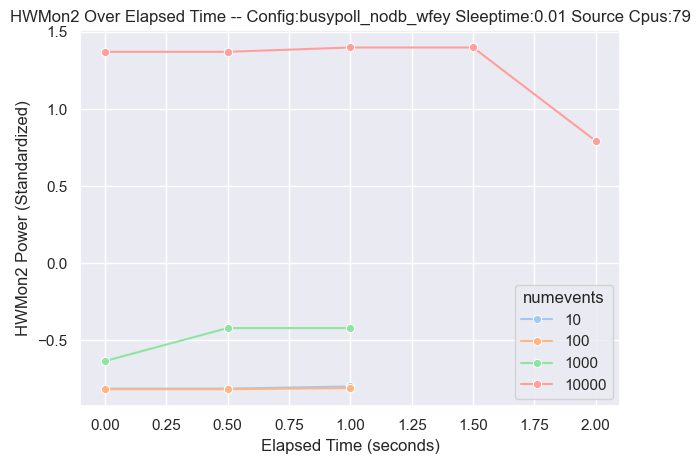

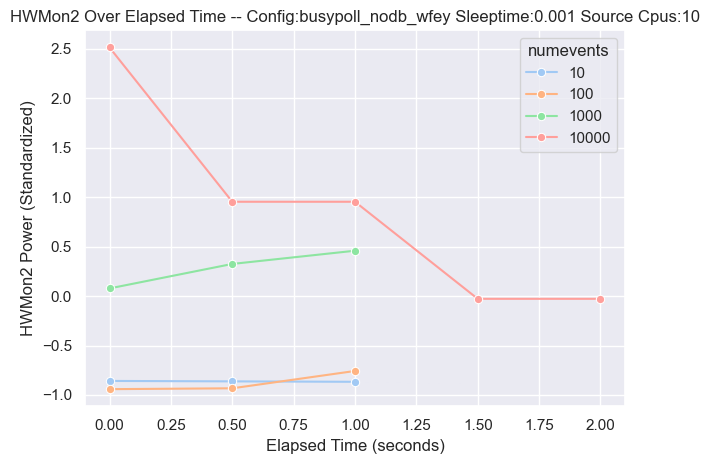

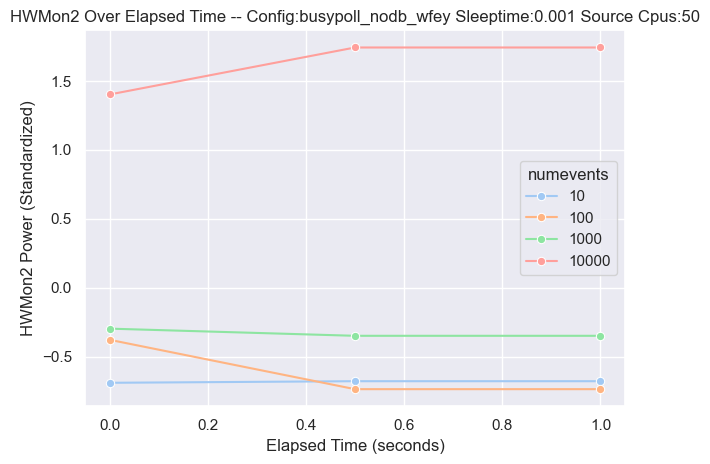

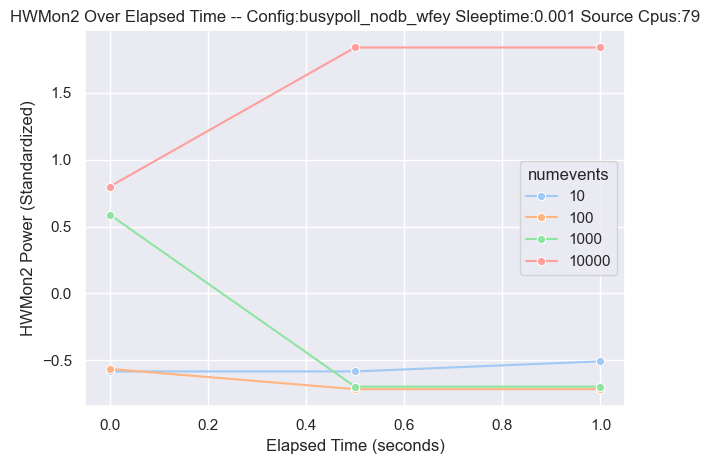

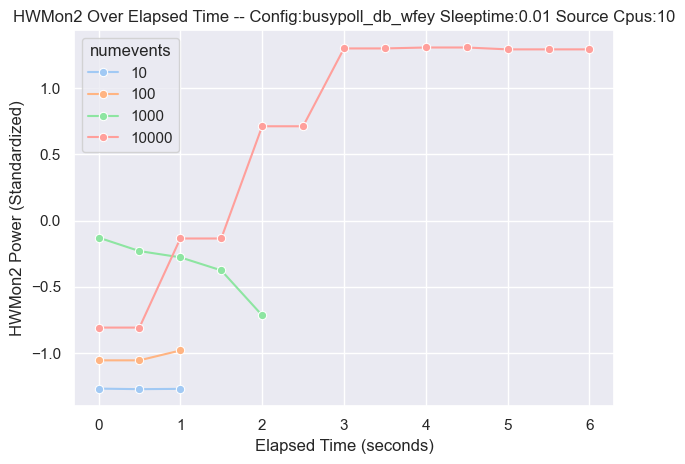

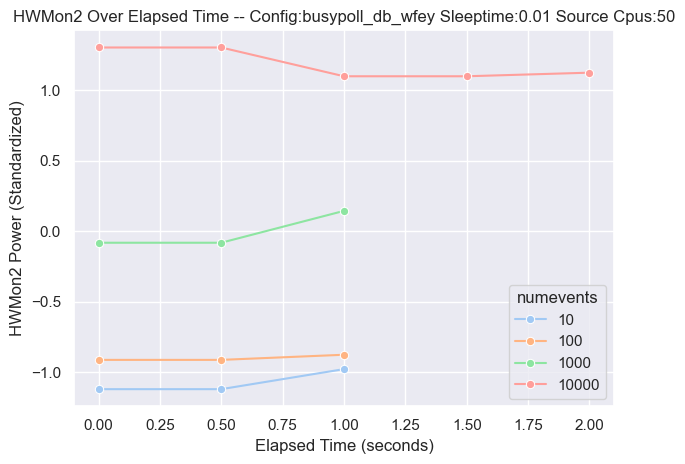

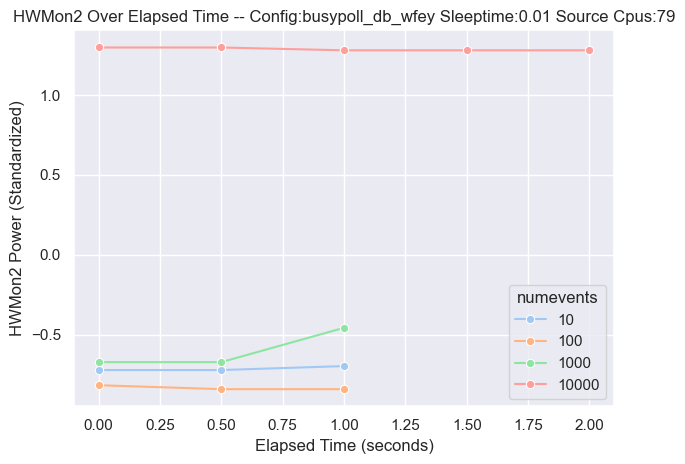

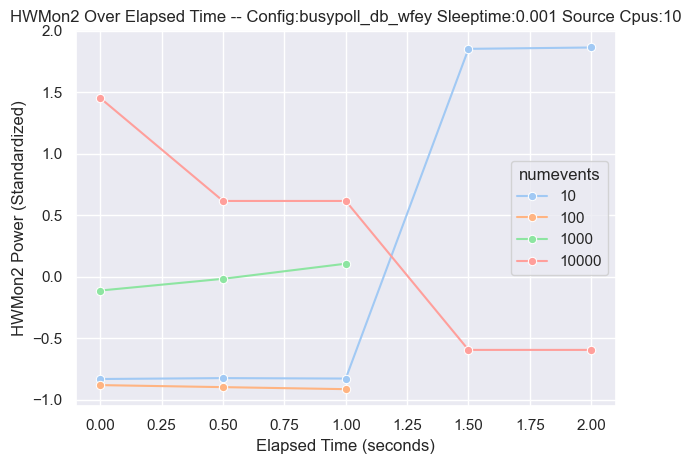

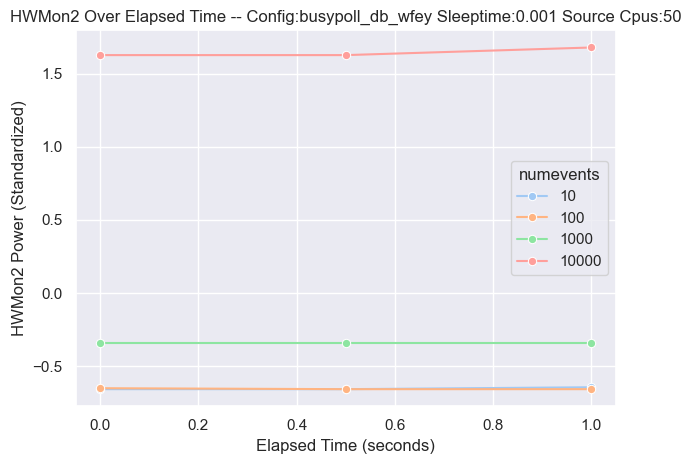

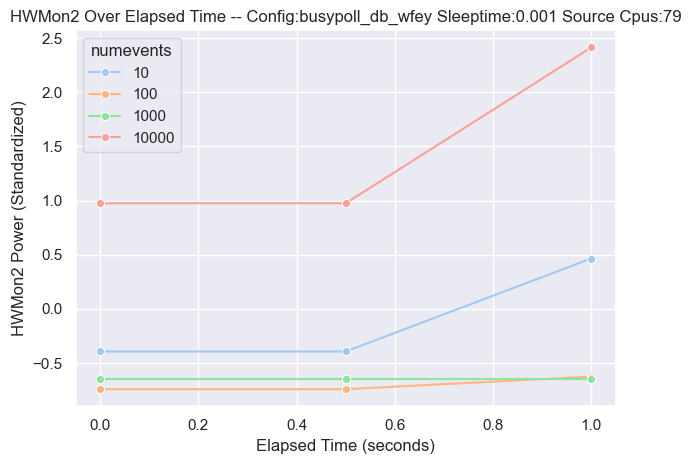

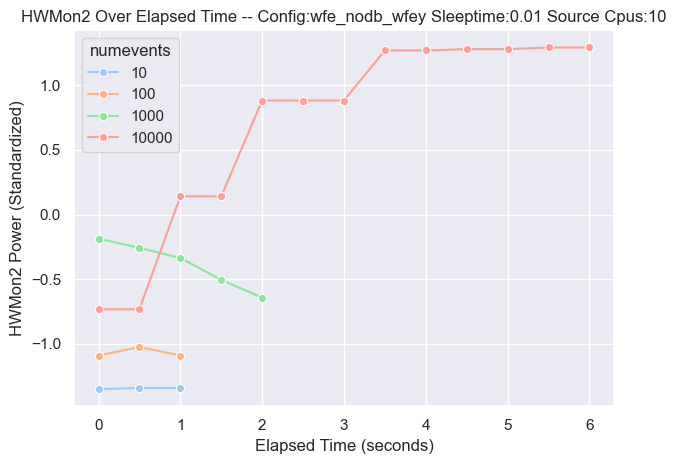

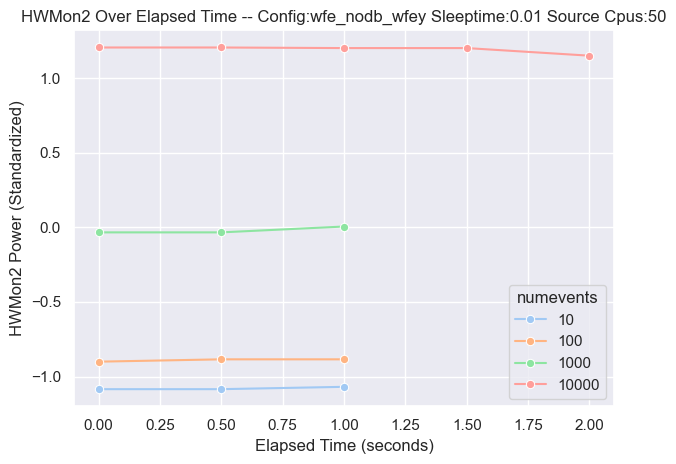

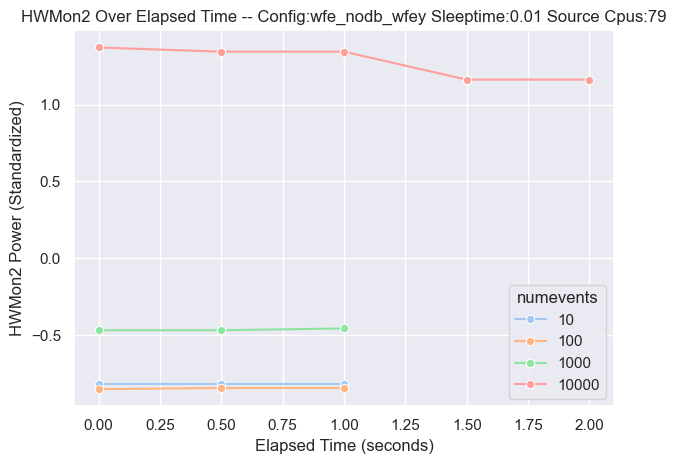

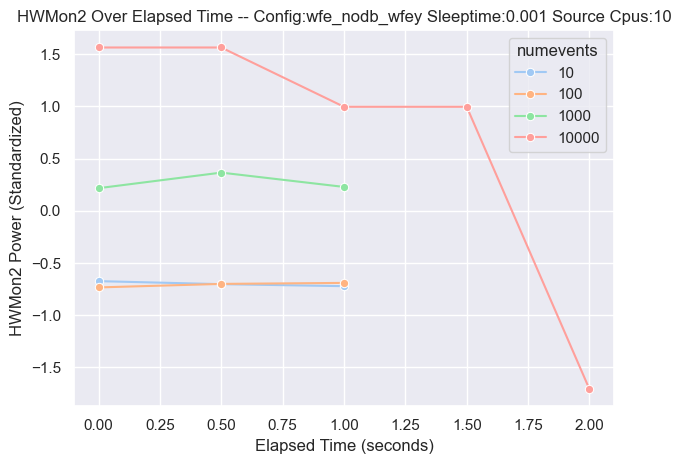

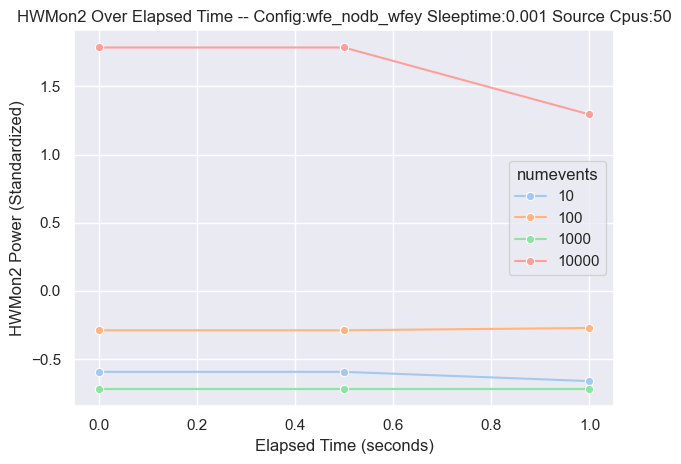

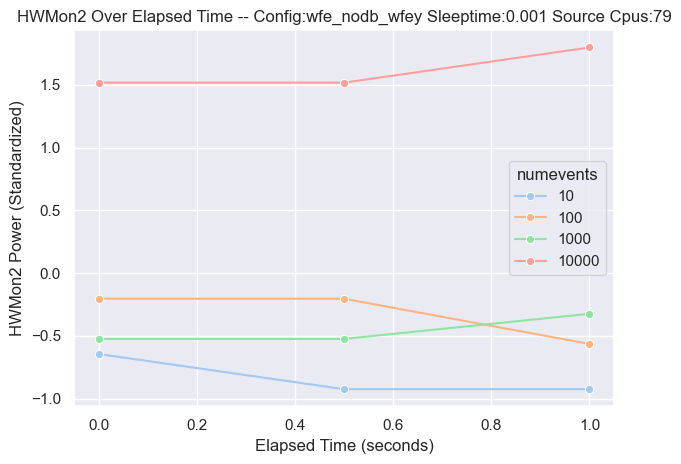

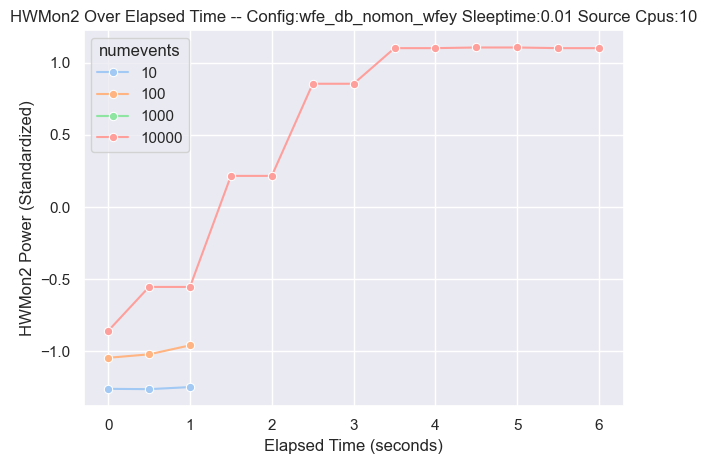

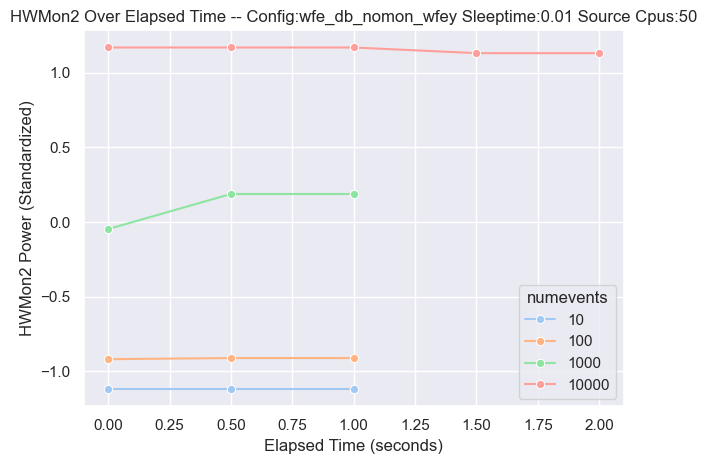

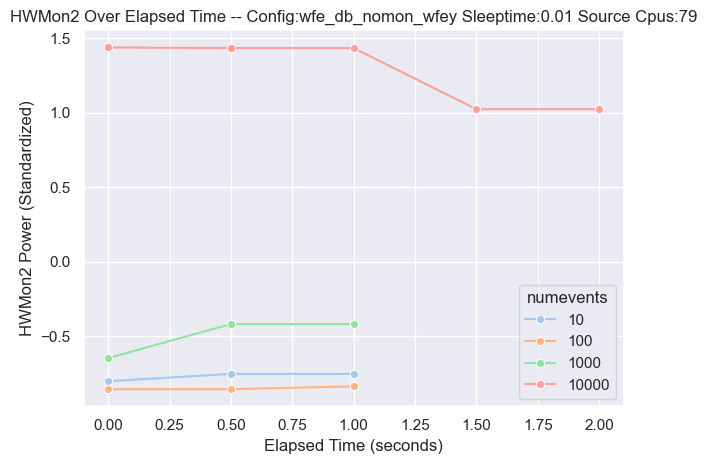

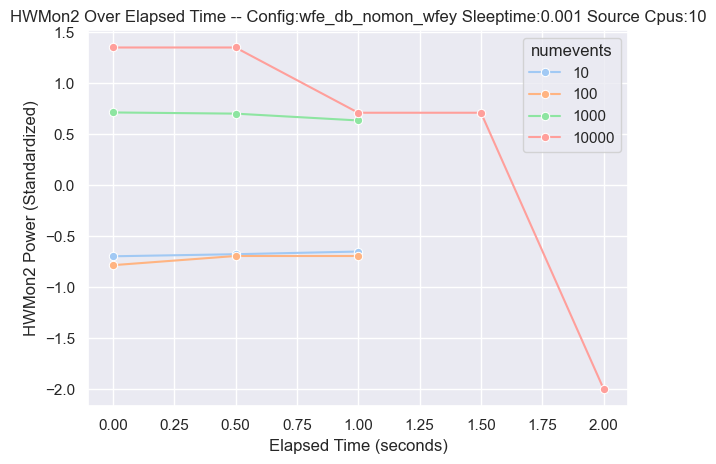

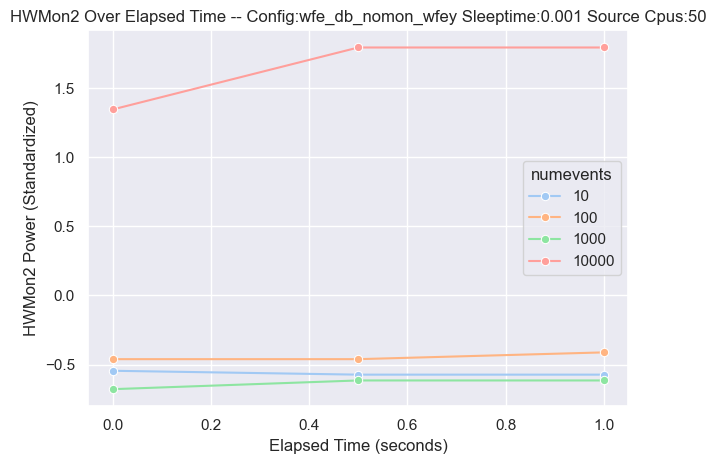

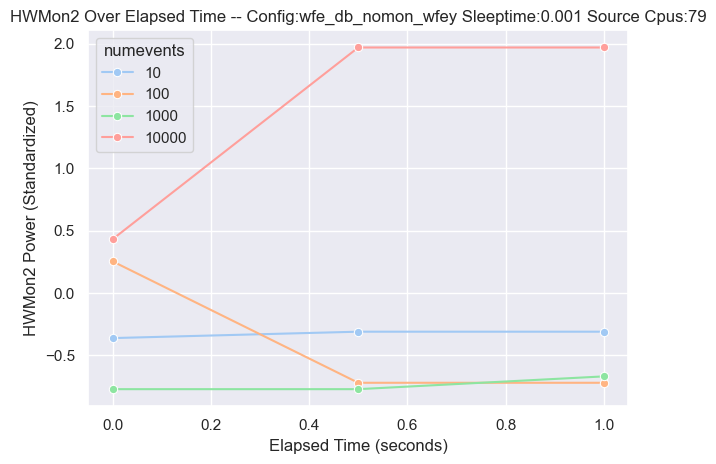

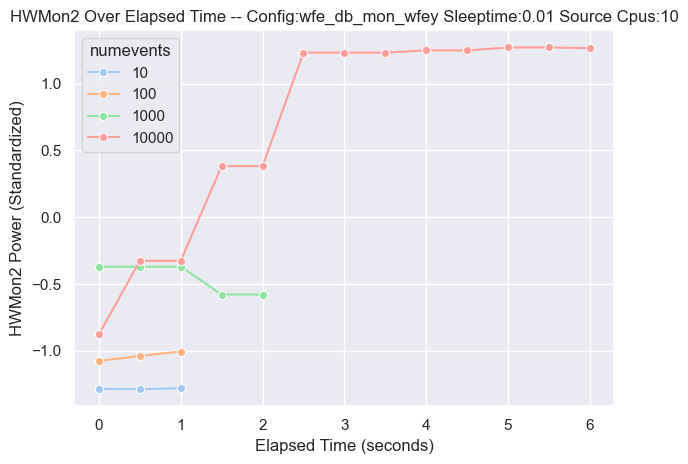

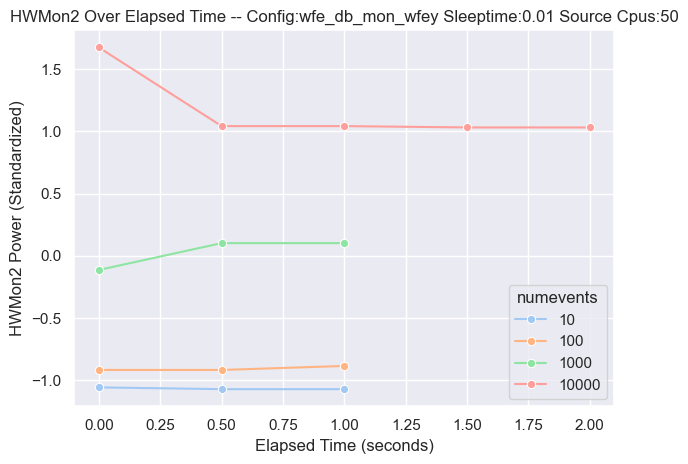

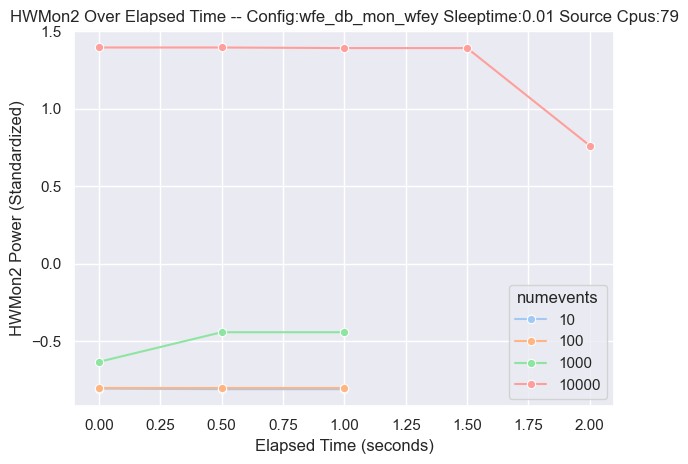

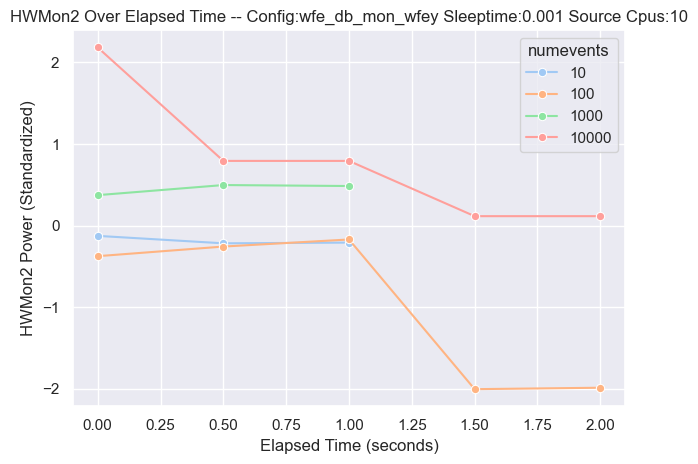

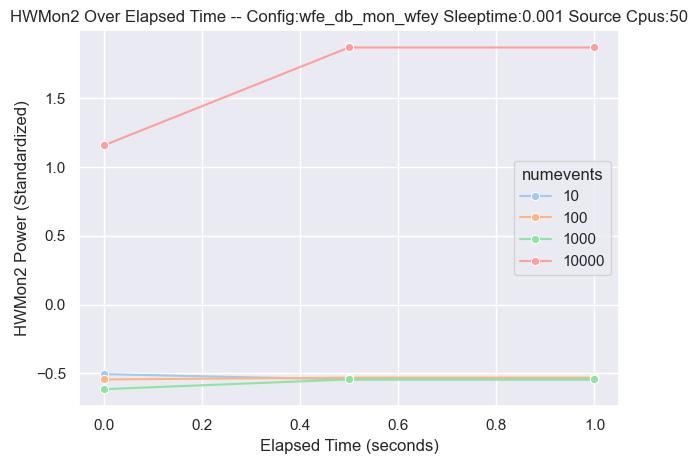

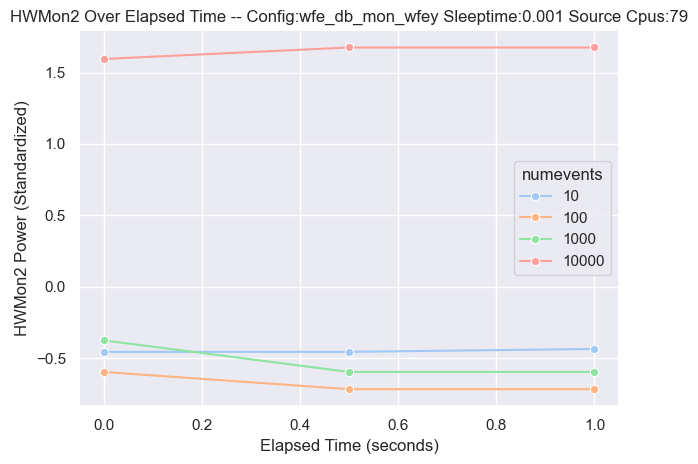

In [8]:
for c in CONFIGS:
    for s in sleeptimesubset:
        for sc in sourceCPUsubset:
            plt.figure()
            config_set = flat_data[ (flat_data['configs'] == c) &
                                    (flat_data['sleeptime'] == s) &
                                    (flat_data['sourceCPUs'] == sc)]
            
            mean_set = config_set.assign( hwmon2_standard = (config_set['hwmon2'] - config_set['hwmon2'].mean()) / (config_set['hwmon2'].std()) )
            #print(mean_set)
            
            sns.lineplot(
            data=mean_set, 
                x='time',
                y='hwmon2_standard',
                hue='numevents',
                palette='pastel',
                marker='o',        # Adds markers at each point
                errorbar=None
            )
        
            plt.title('HWMon2 Over Elapsed Time -- Config:'+c+' Sleeptime:'+s+' Source Cpus:'+sc)
            plt.xlabel('Elapsed Time (seconds)')
            plt.ylabel('HWMon2 Power (Standardized)')
            plt.tight_layout()

##### Power values over time -- Differentiated by Config

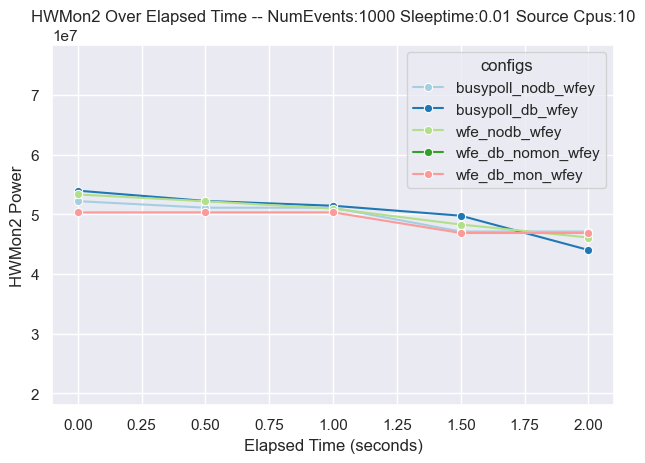

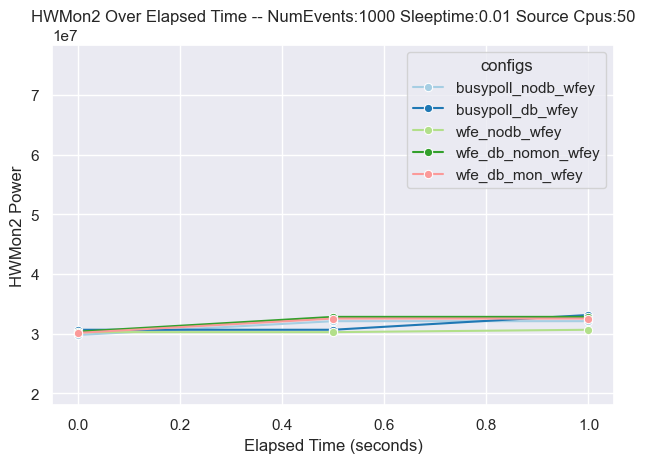

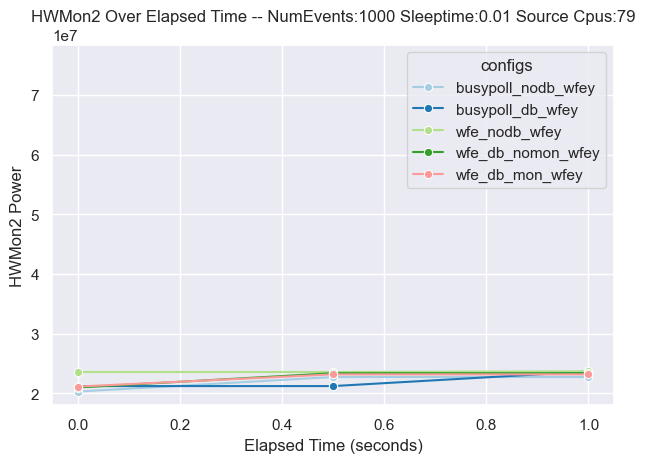

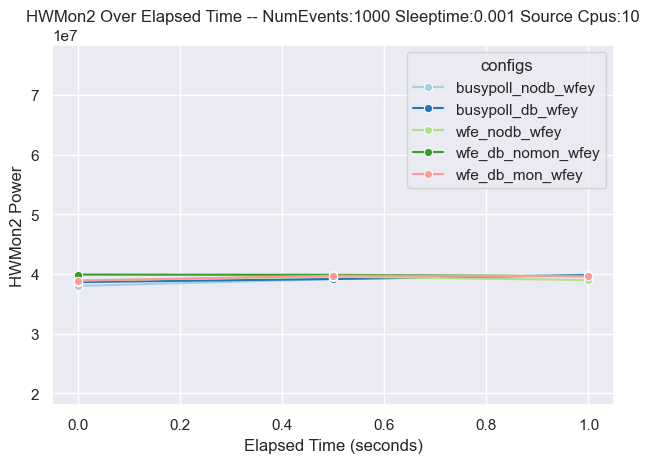

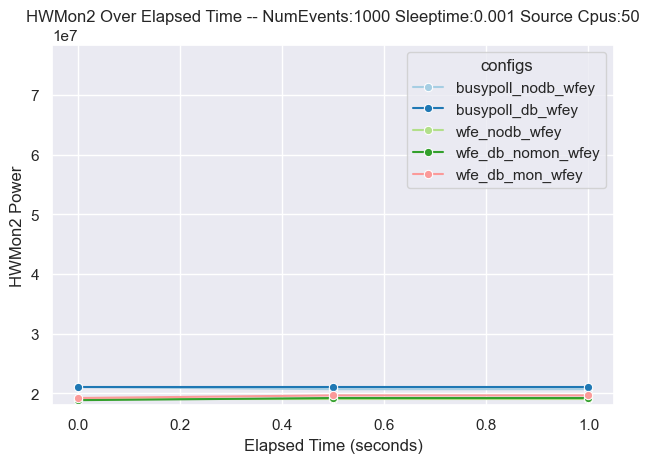

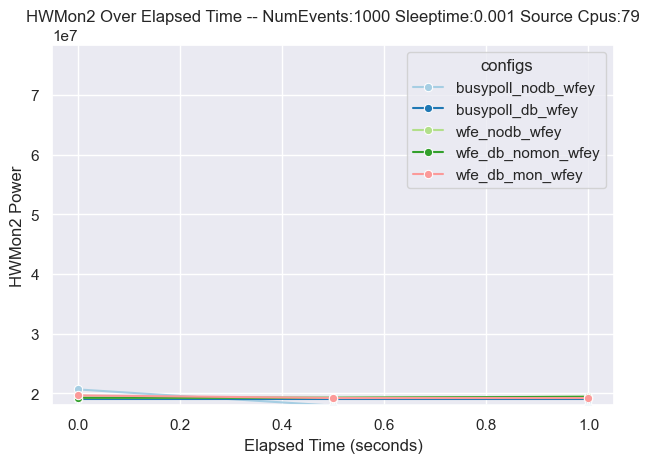

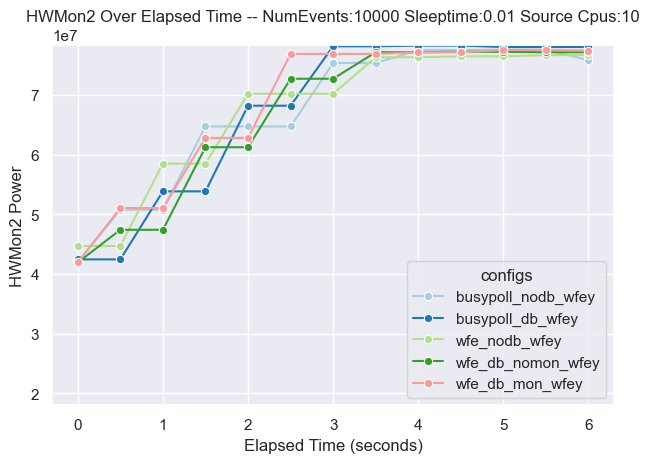

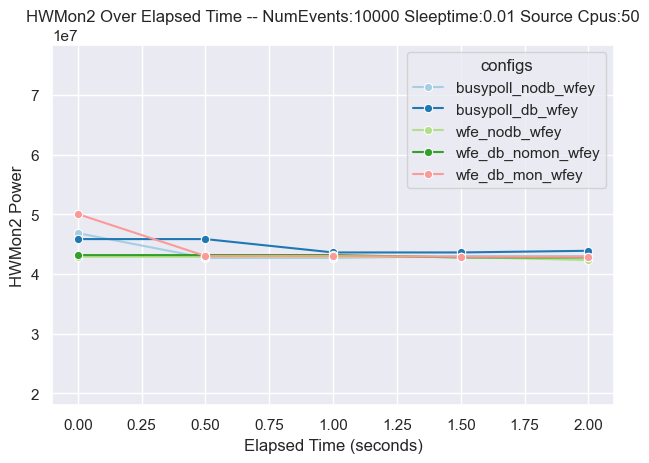

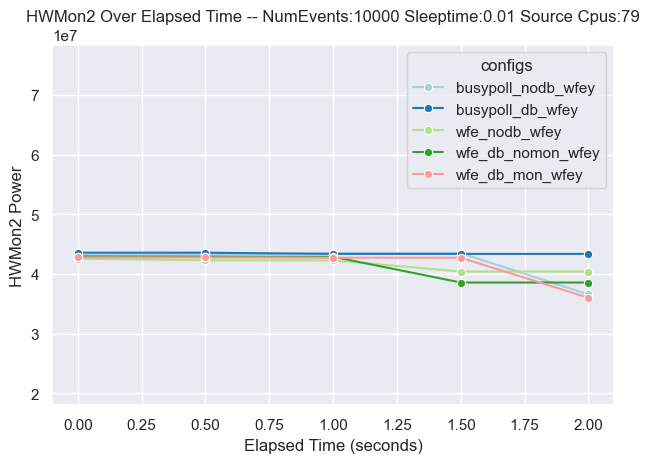

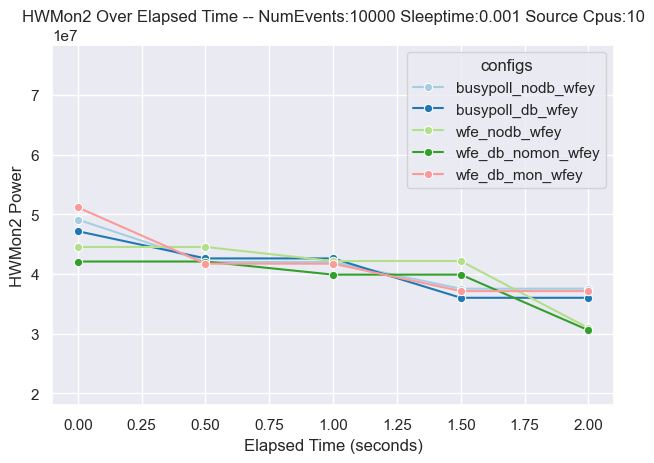

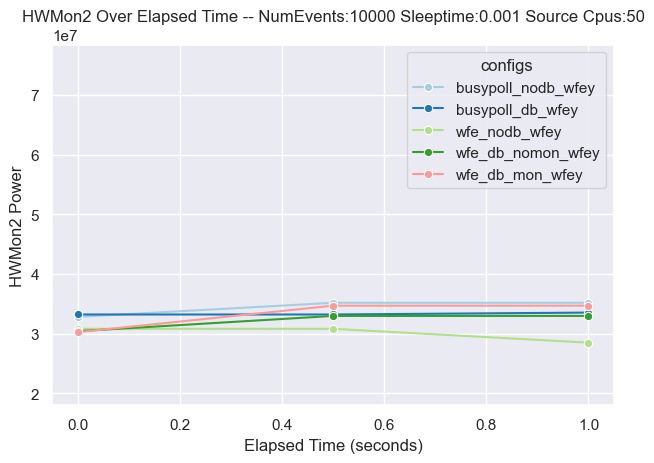

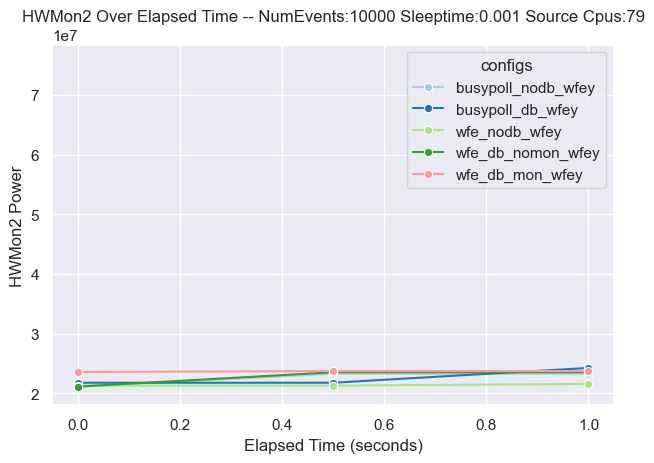

In [9]:
for e in eventsubset:
    for s in sleeptimesubset:
        for sc in sourceCPUsubset:
            plt.figure()
            config_set = flat_data[ (flat_data['numevents'] == e) &
                                    (flat_data['sleeptime'] == s) &
                                    (flat_data['sourceCPUs'] == sc)]
            #print(config_set)
            sns.lineplot(
            data=config_set, 
                x='time',
                y='hwmon2',
                hue='configs',
                marker='o',        # Adds markers at each point
                errorbar=None
            )
        
            plt.title('HWMon2 Over Elapsed Time -- NumEvents:'+str(e)+' Sleeptime:'+s+' Source Cpus:'+sc)
            plt.xlabel('Elapsed Time (seconds)')
            plt.ylabel('HWMon2 Power')
            plt.ylim(flat_data['hwmon2_mean'].min(),flat_data['hwmon2_mean'].max())
            plt.tight_layout()

##### Power values over time -- Differentiated by Config -- Standarized

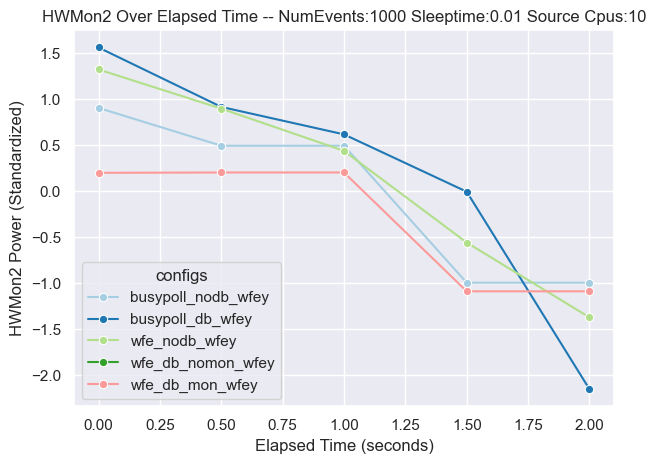

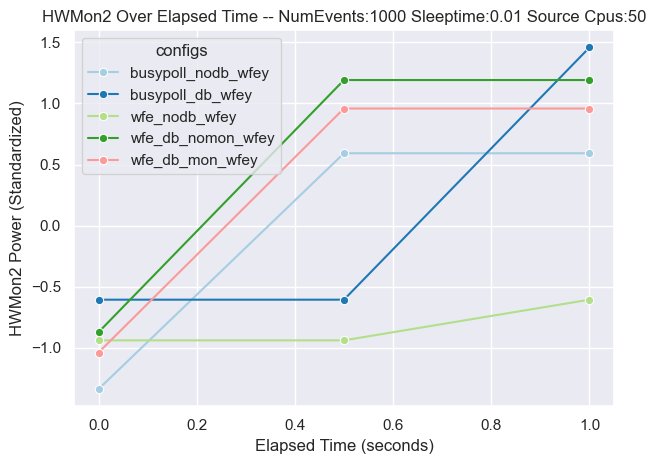

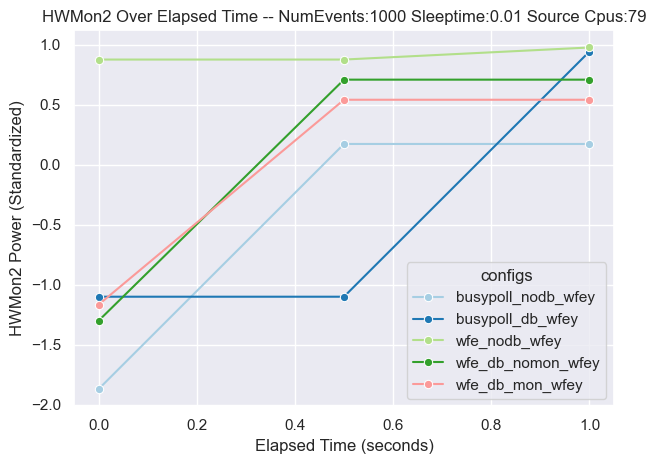

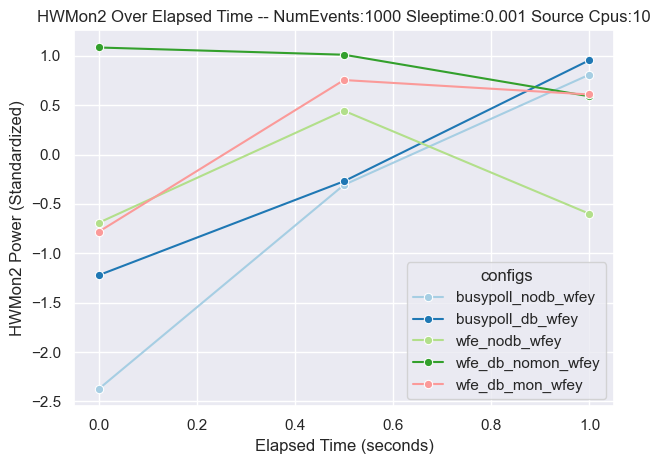

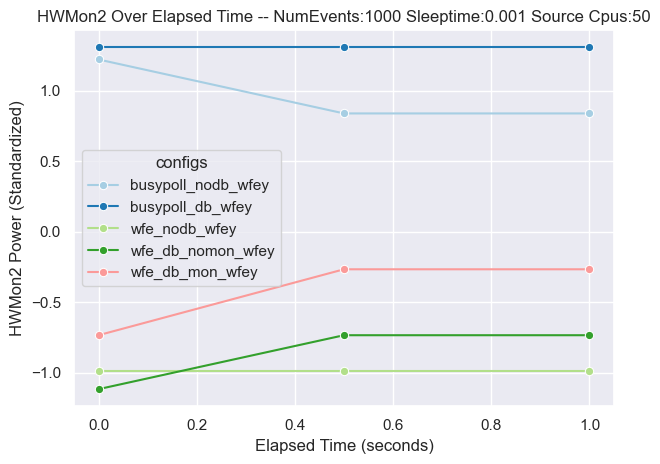

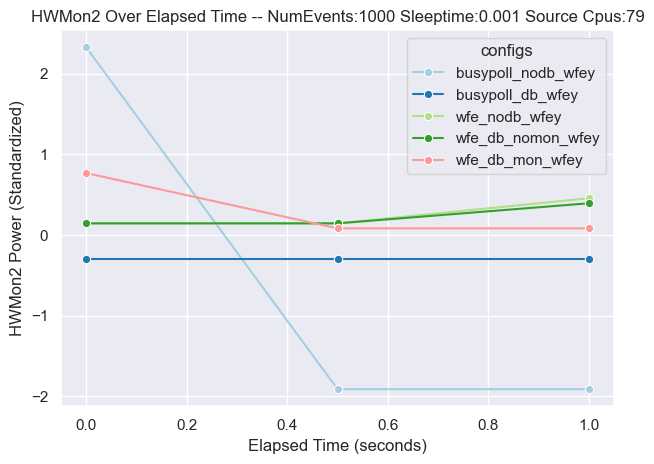

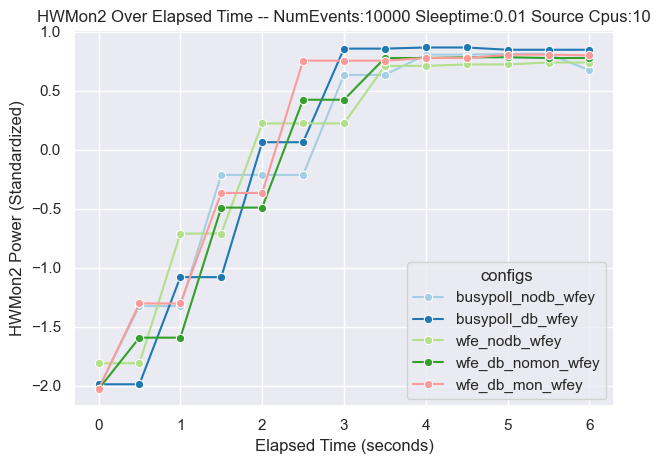

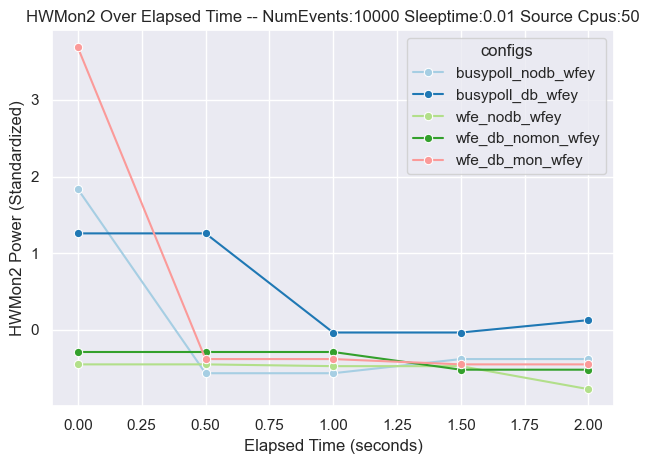

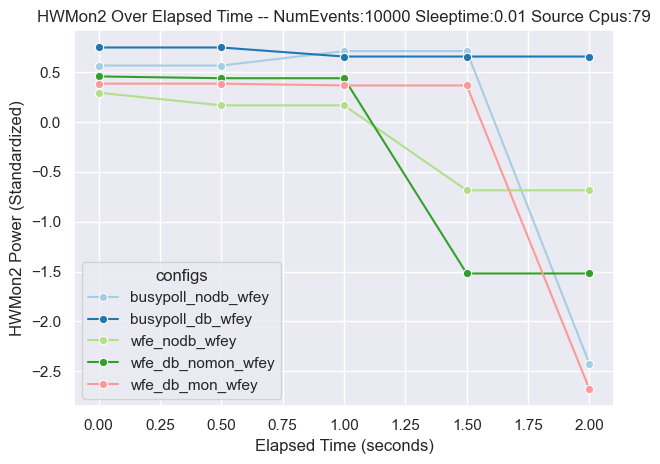

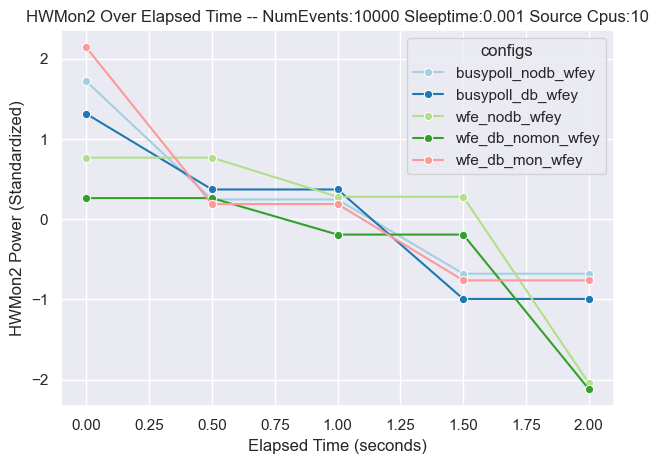

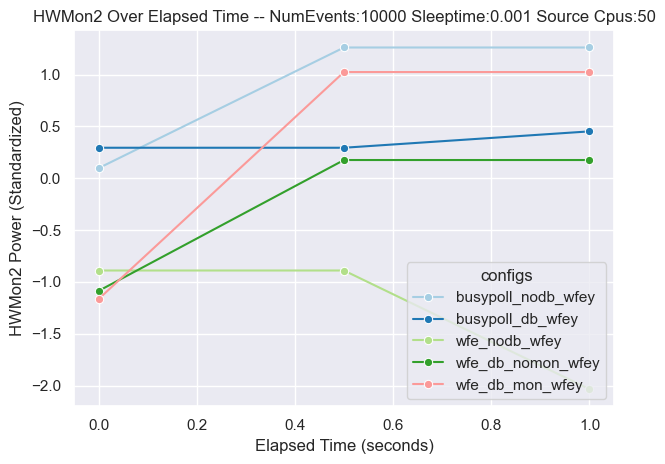

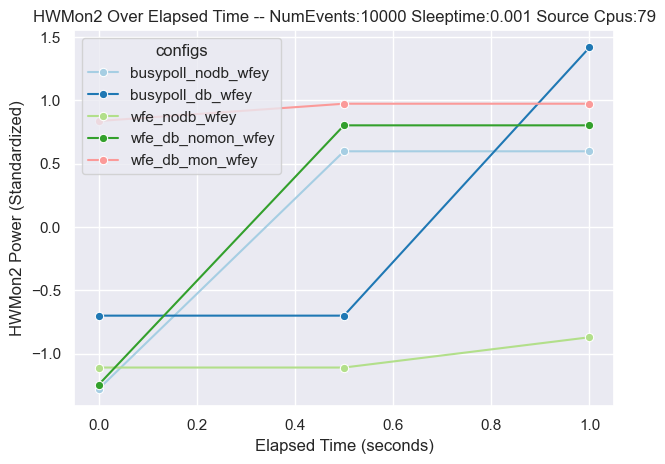

In [10]:
for e in eventsubset:
    for s in sleeptimesubset:
        for sc in sourceCPUsubset:
            plt.figure()
            config_set = flat_data[ (flat_data['numevents'] == e) &
                                    (flat_data['sleeptime'] == s) &
                                    (flat_data['sourceCPUs'] == sc)]
            #print("config: ")
            #print(config_set)

            ## Is this giving me the power numbers mean standardized (z-score) over all the values
            ## over one set of values ...? Do I want it over all of them... b/c they might start 
            ## at different values
            mean_set = config_set.assign( hwmon2_standard = (config_set['hwmon2'] - config_set['hwmon2'].mean()) / (config_set['hwmon2'].std()) )
            #print(mean_set)

            #print("config set [hwmon]: ")
            #print(config_set['hwmon2'])
            
            sns.lineplot(
                data=mean_set, 
                x='time',
                y='hwmon2_standard',
                hue='configs',
                marker='o',        # Adds markers at each point
                errorbar=None
            )
        
            plt.title('HWMon2 Over Elapsed Time -- NumEvents:'+str(e)+' Sleeptime:'+s+' Source Cpus:'+sc)
            plt.xlabel('Elapsed Time (seconds)')
            plt.ylabel('HWMon2 Power (Standardized)')
            plt.tight_layout()

##### Min/Max/Mean per Config

/var/folders/_g/p1k71chj0gz6j8jb7c48r03c0000gn/T/ipykernel_43358/339013698.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

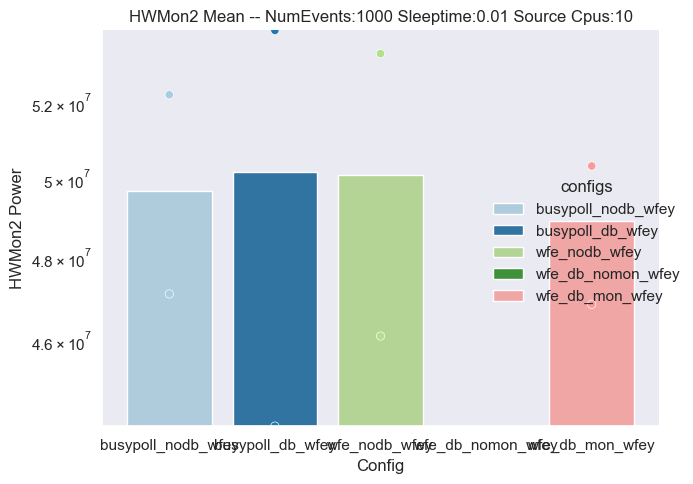

<Figure size 640x480 with 0 Axes>

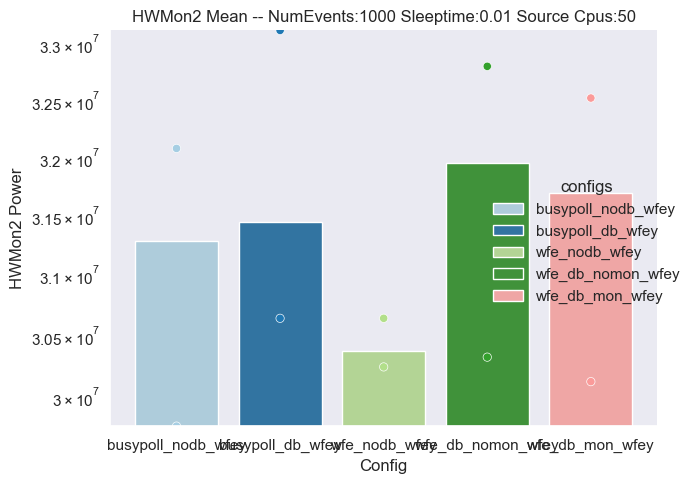

<Figure size 640x480 with 0 Axes>

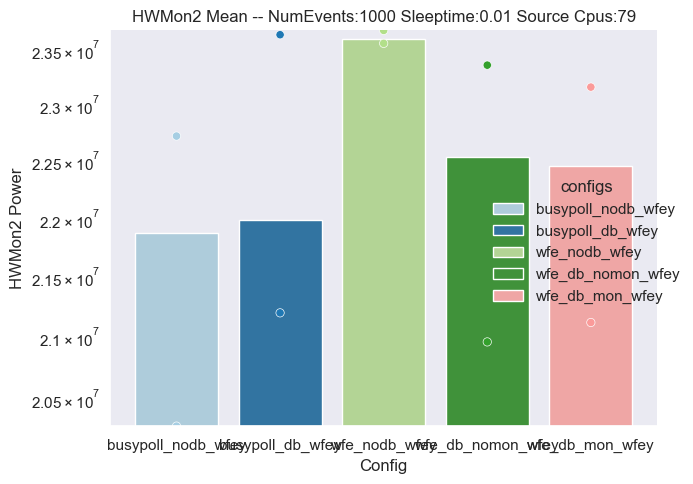

<Figure size 640x480 with 0 Axes>

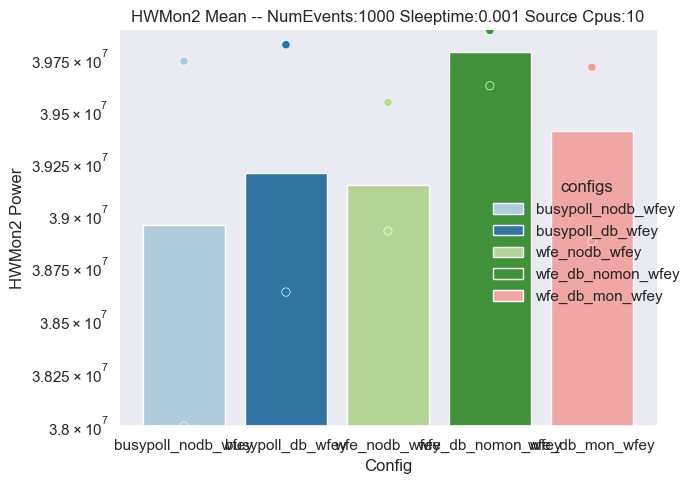

<Figure size 640x480 with 0 Axes>

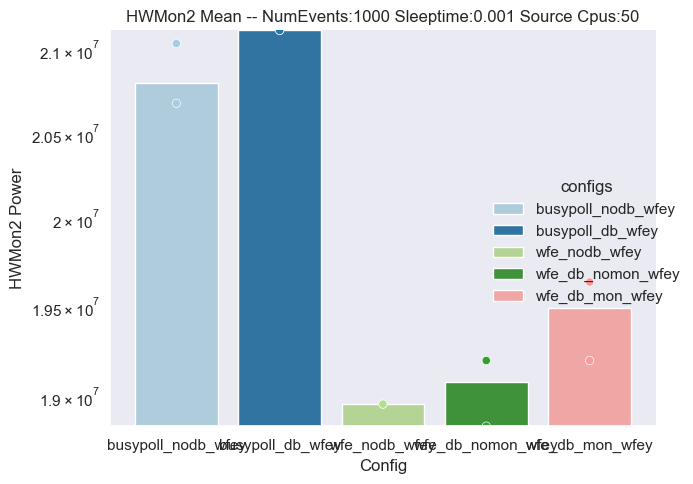

<Figure size 640x480 with 0 Axes>

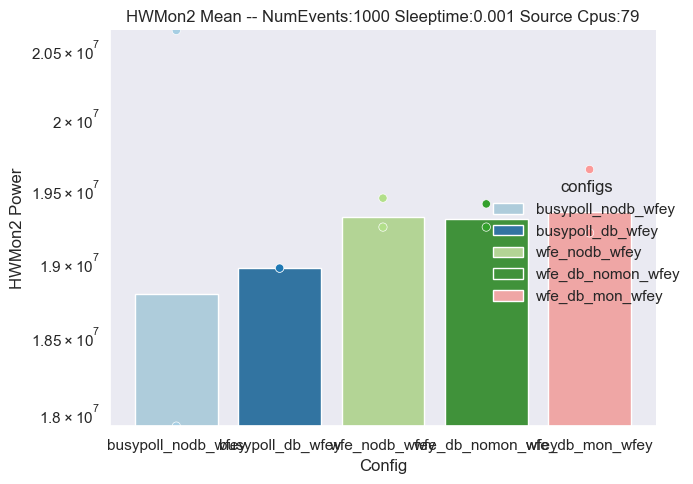

<Figure size 640x480 with 0 Axes>

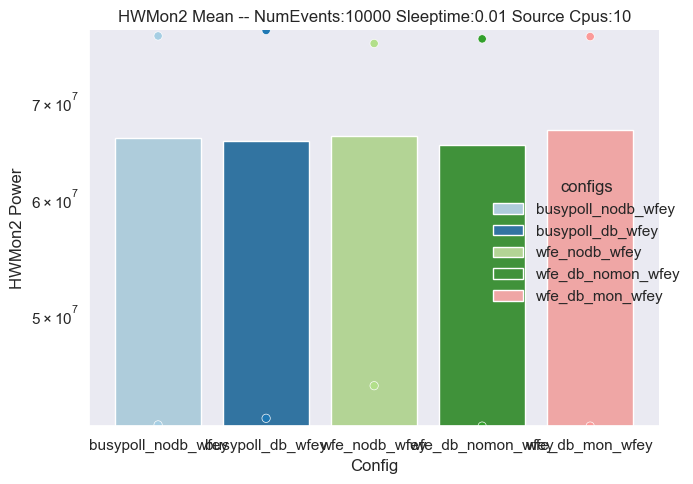

<Figure size 640x480 with 0 Axes>

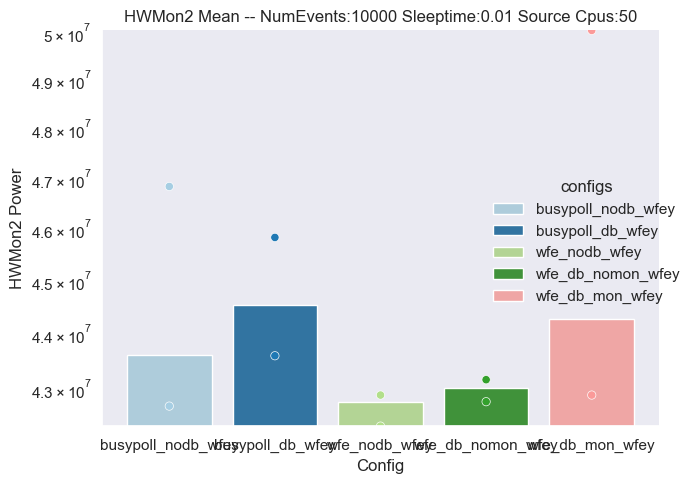

<Figure size 640x480 with 0 Axes>

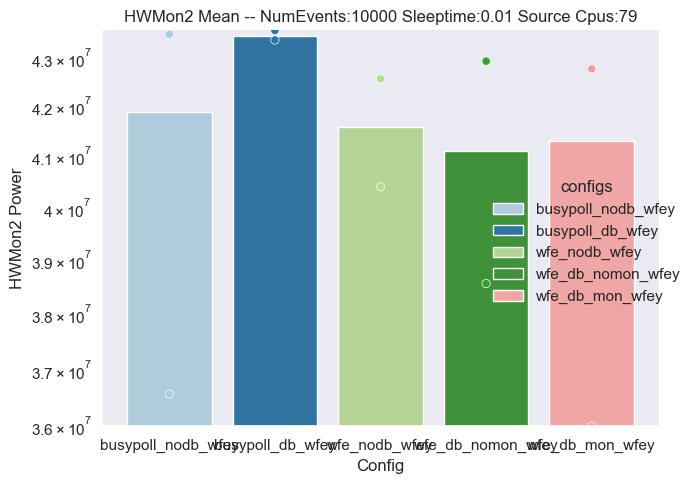

<Figure size 640x480 with 0 Axes>

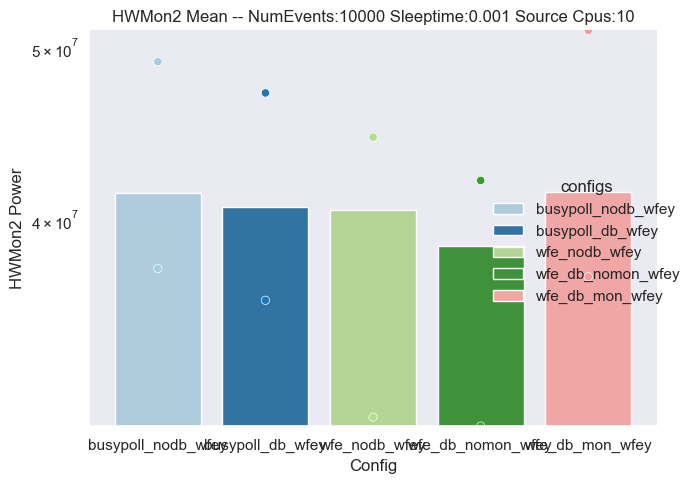

<Figure size 640x480 with 0 Axes>

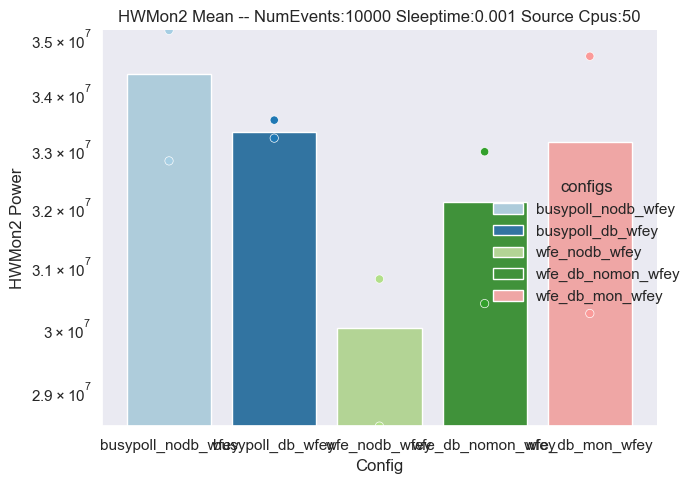

<Figure size 640x480 with 0 Axes>

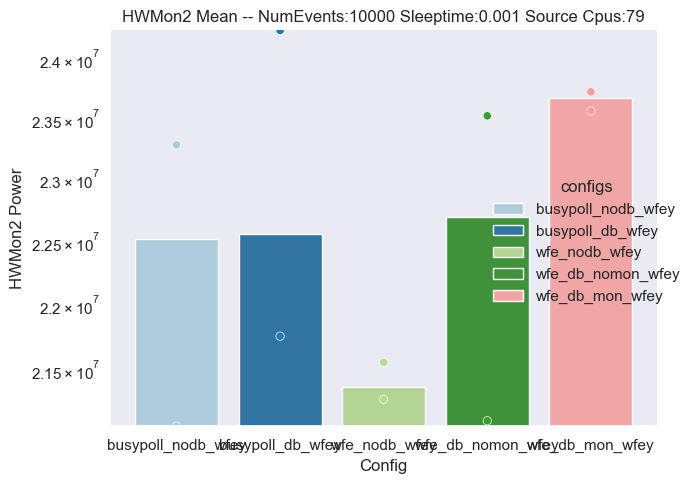

In [11]:
for e in eventsubset:
    for s in sleeptimesubset:
        for sc in sourceCPUsubset:
            plt.figure()
            config_set = wfey_output[ (wfey_output['numevents'] == e) &
                                    (wfey_output['sleeptime'] == s) &
                                    (wfey_output['sourceCPUs'] == sc)]

            #mean_set = config_set.assign( hwmon2_standard = (config_set['hwmon2'] - config_set['hwmon2'].mean()) / (config_set['hwmon2'].std()) )
            #print(config_set)
            
            g = sns.catplot(
            data=config_set, 
            kind="bar",
            x='configs',
            y='hwmon2_mean',
            hue='configs',
            legend=True,
            errorbar=None
            )

            sns.scatterplot(
            data=config_set,
            x='configs',
            y='hwmon2_min',
            hue='configs',
            legend=False
            )

            sns.scatterplot(
            data=config_set,
            x='configs',
            y='hwmon2_max',
            hue='configs',
            legend=False
            )

            g.fig.get_axes()[0].set_yscale('log')

            #plot_errorbars(lambda x: (x.min(), x.max()))
        
            plt.title('HWMon2 Mean -- NumEvents:'+str(e)+' Sleeptime:'+s+' Source Cpus:'+sc)
            plt.xlabel('Config')
            plt.ylabel('HWMon2 Power')
            #plt.ylim(flat_data['hwmon2_min'].min(),flat_data['hwmon2_max'].max()) # use this to arg set per config
            plt.ylim(config_set['hwmon2_min'].min(),config_set['hwmon2_max'].max()) # use this to compare the configs per arg set
            plt.tight_layout()

##### Power Differences

/var/folders/_g/p1k71chj0gz6j8jb7c48r03c0000gn/T/ipykernel_43358/211236082.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

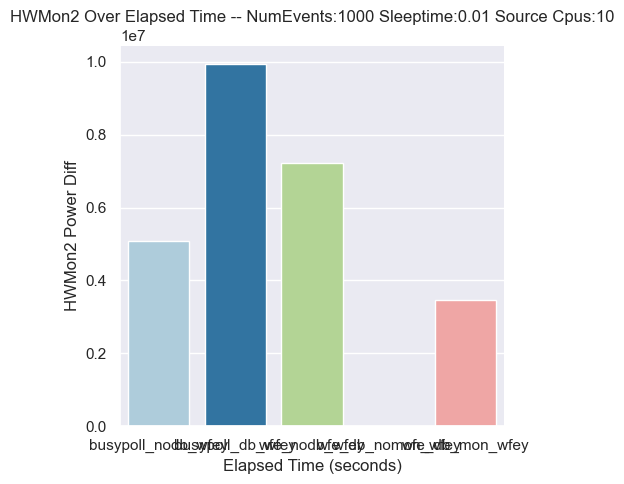

<Figure size 640x480 with 0 Axes>

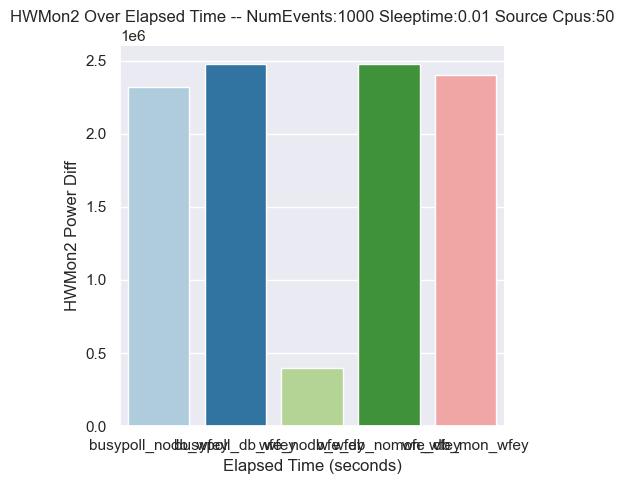

<Figure size 640x480 with 0 Axes>

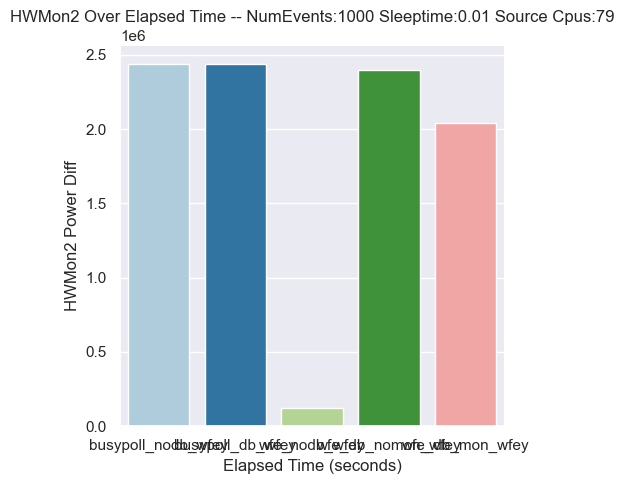

<Figure size 640x480 with 0 Axes>

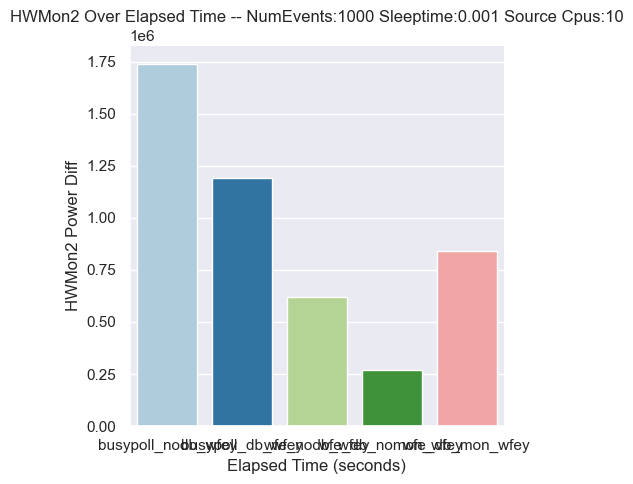

<Figure size 640x480 with 0 Axes>

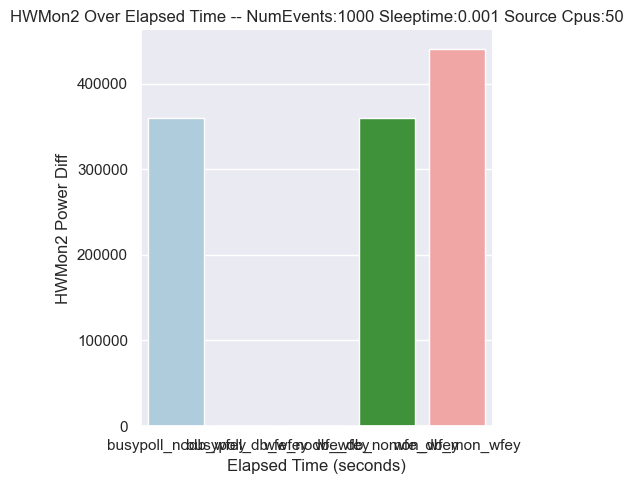

<Figure size 640x480 with 0 Axes>

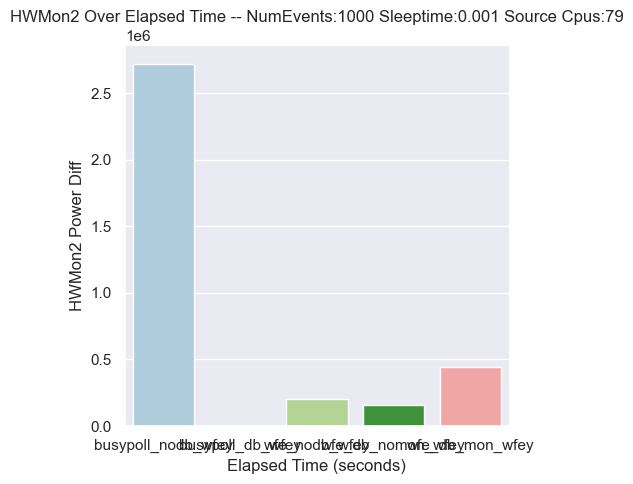

<Figure size 640x480 with 0 Axes>

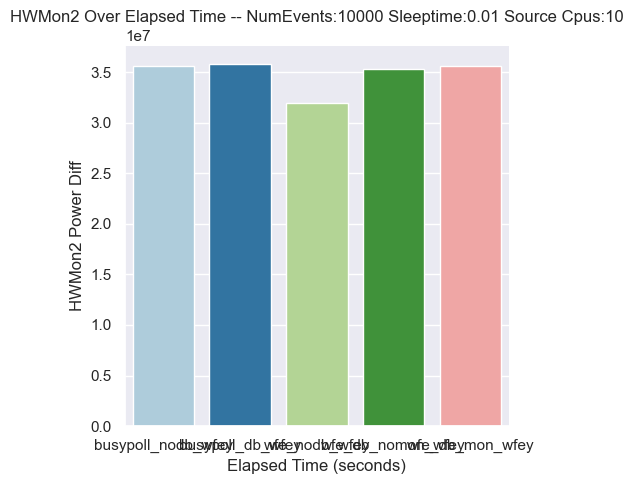

<Figure size 640x480 with 0 Axes>

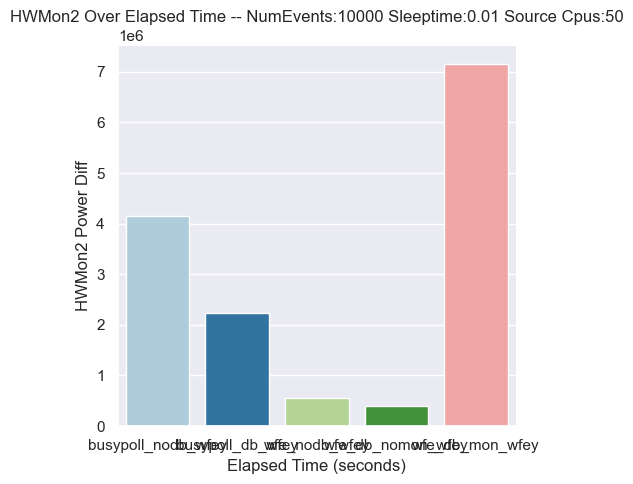

<Figure size 640x480 with 0 Axes>

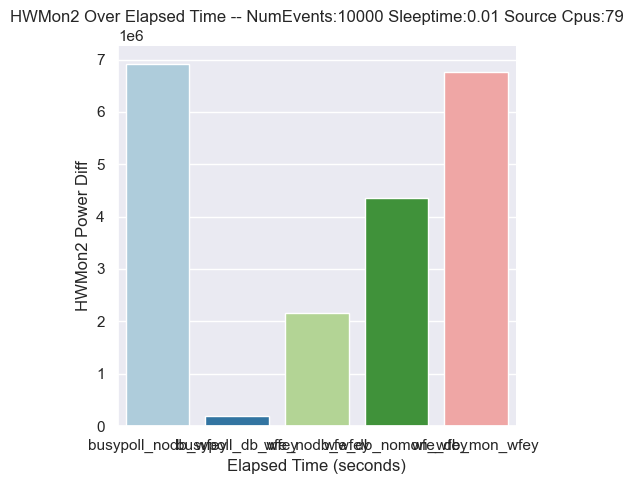

<Figure size 640x480 with 0 Axes>

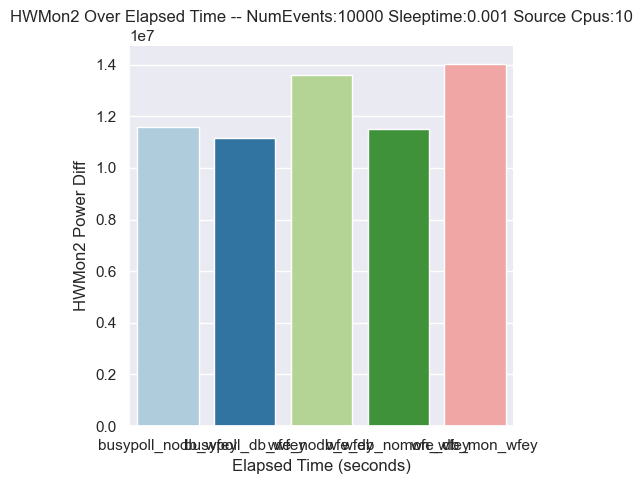

<Figure size 640x480 with 0 Axes>

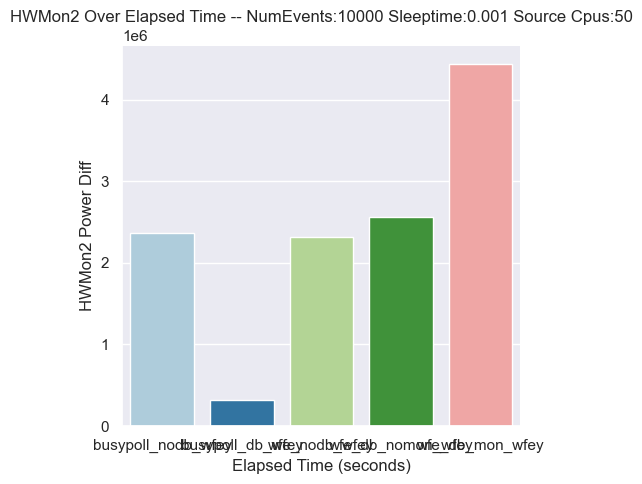

<Figure size 640x480 with 0 Axes>

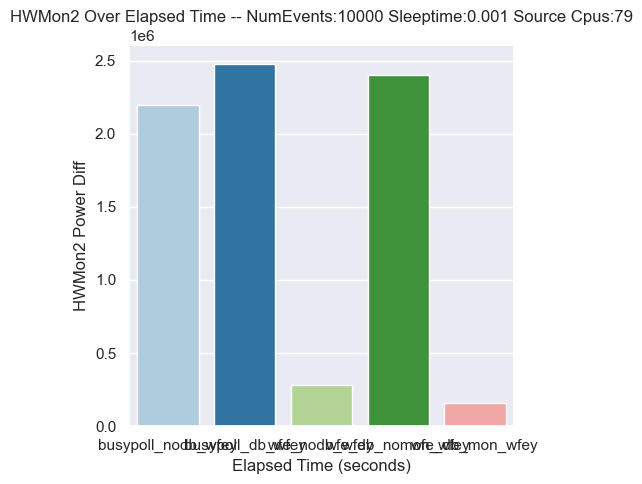

In [12]:
for e in eventsubset:
    for s in sleeptimesubset:
        for sc in sourceCPUsubset:
            plt.figure()
            config_set = wfey_output[ (wfey_output['numevents'] == e) &
                                    (wfey_output['sleeptime'] == s) &
                                    (wfey_output['sourceCPUs'] == sc)]
            config_set['hwmon2_diff'] = config_set['hwmon2_max'] - config_set['hwmon2_min']
            #print(config_set)
            sns.catplot(
                data=config_set, 
                kind="bar",
                x='configs',
                y='hwmon2_diff',
                hue='configs',
                errorbar=None
            )
        
            plt.title('HWMon2 Over Elapsed Time -- NumEvents:'+str(e)+' Sleeptime:'+s+' Source Cpus:'+sc)
            plt.xlabel('Elapsed Time (seconds)')
            plt.ylabel('HWMon2 Power Diff')
            #plt.ylim(config_set['hwmon2_min'].min(),config_set['hwmon2_max'].max())
            plt.tight_layout()

##### Total Watts Used

/var/folders/_g/p1k71chj0gz6j8jb7c48r03c0000gn/T/ipykernel_43358/3239941789.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

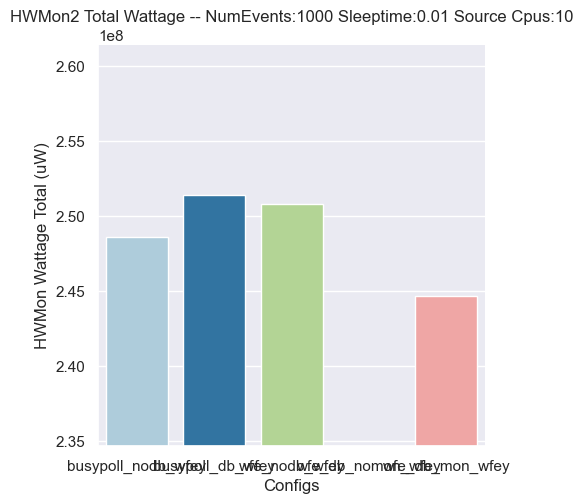

<Figure size 640x480 with 0 Axes>

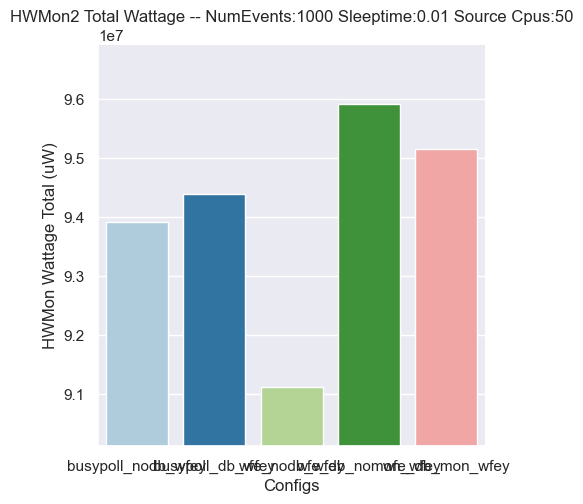

<Figure size 640x480 with 0 Axes>

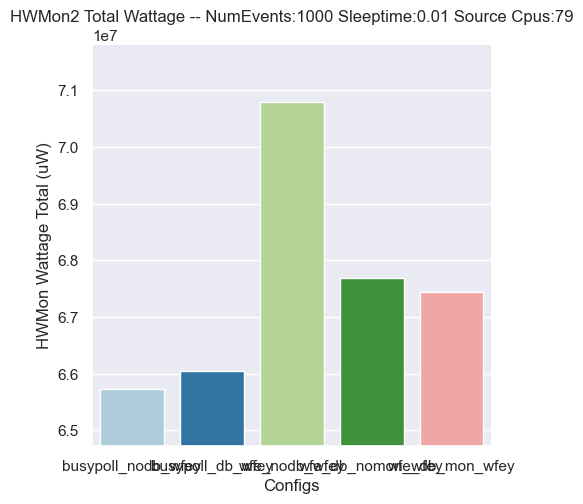

<Figure size 640x480 with 0 Axes>

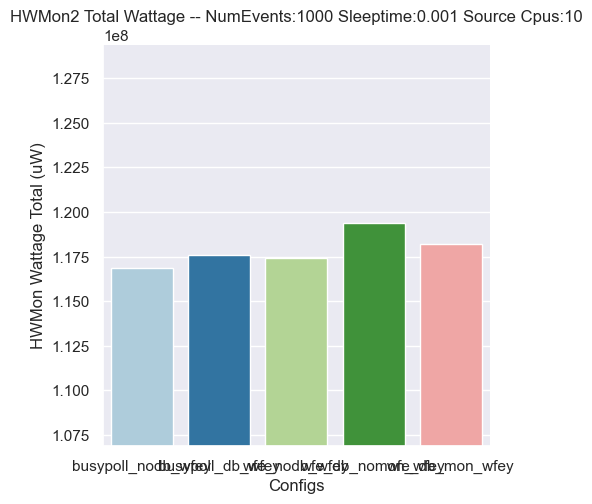

<Figure size 640x480 with 0 Axes>

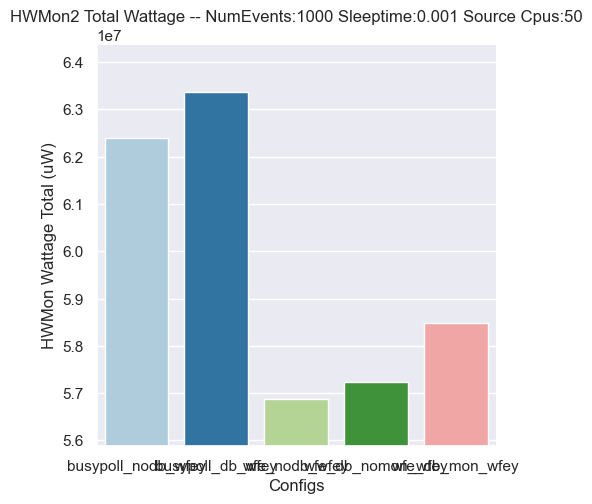

<Figure size 640x480 with 0 Axes>

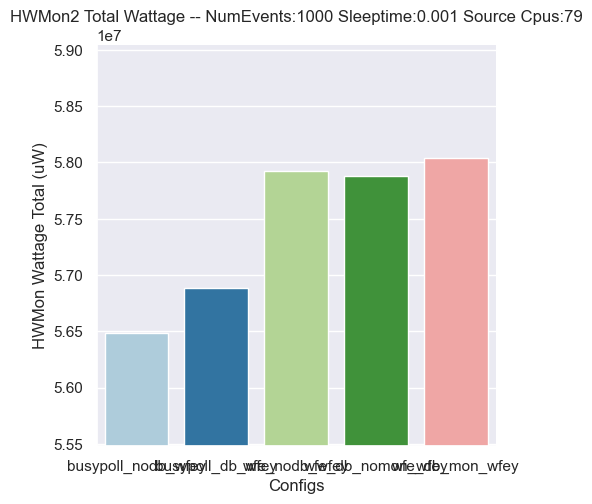

<Figure size 640x480 with 0 Axes>

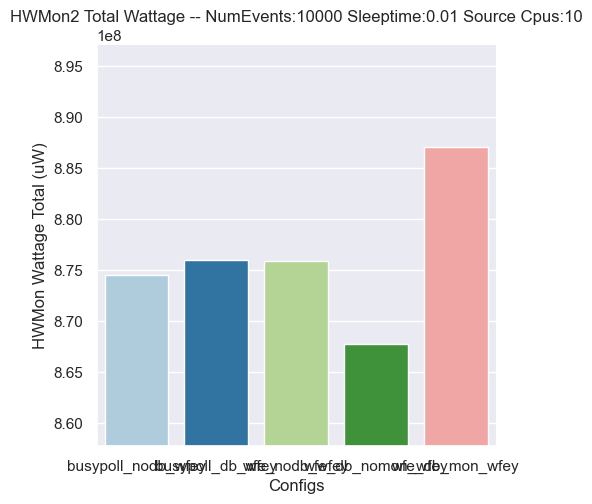

<Figure size 640x480 with 0 Axes>

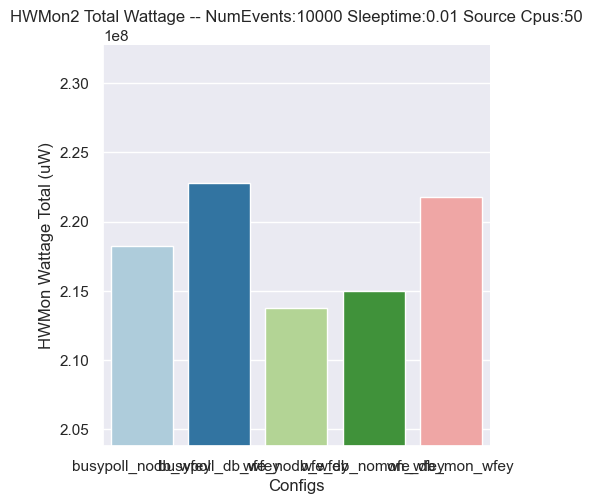

<Figure size 640x480 with 0 Axes>

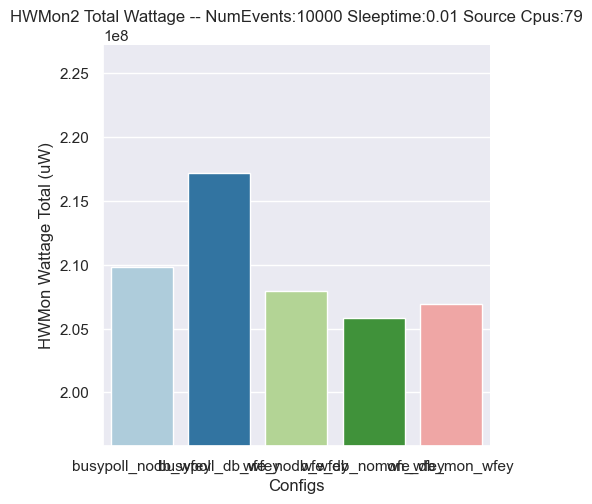

<Figure size 640x480 with 0 Axes>

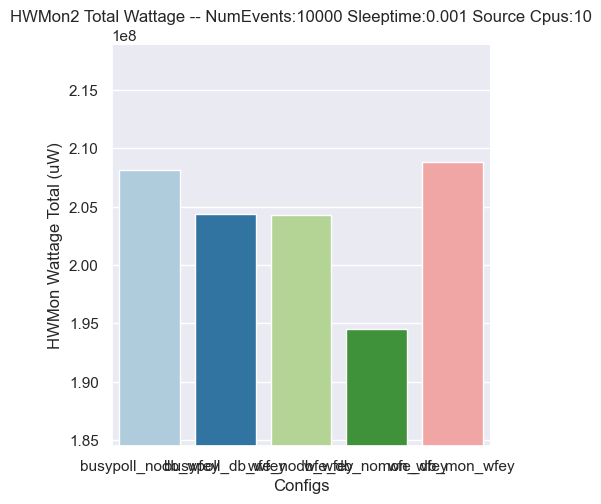

<Figure size 640x480 with 0 Axes>

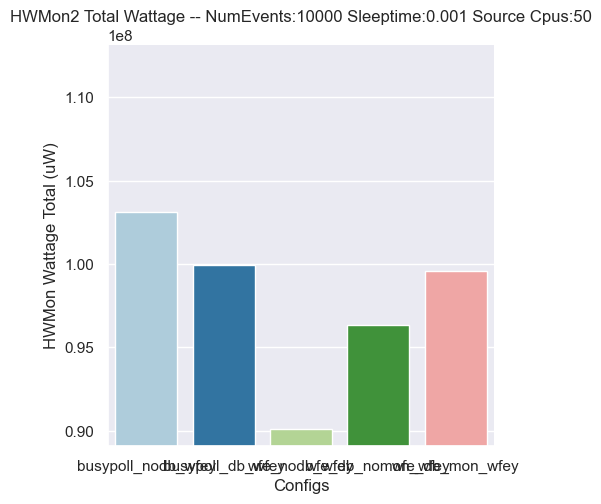

<Figure size 640x480 with 0 Axes>

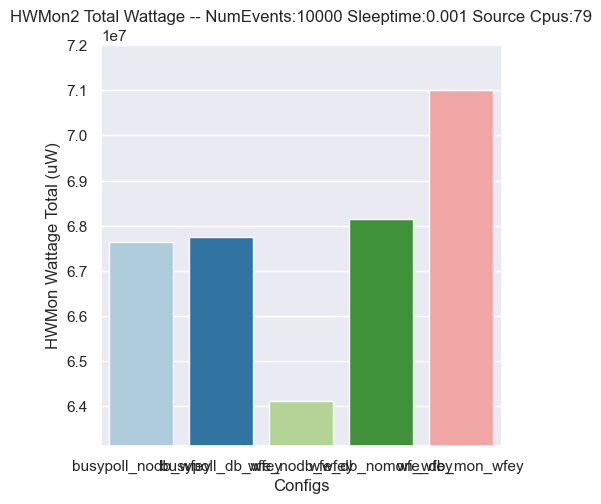

In [13]:
pd.options.mode.chained_assignment = None
for e in eventsubset:
    for s in sleeptimesubset:
        for sc in sourceCPUsubset:
            plt.figure()
            config_set = wfey_output[ (wfey_output['numevents'] == e) &
                                    (wfey_output['sleeptime'] == s) &
                                    (wfey_output['sourceCPUs'] == sc)]

            config_set['hwmon2_total'] = config_set["hwmon2"].apply(lambda x: sum(x))
            #print(config_set['hwmon2_total'])
            
            sns.catplot(
                data=config_set, 
                kind="bar",
                x='configs',
                y='hwmon2_total',
                hue='configs',
                errorbar=None
            )

            min_y = config_set['hwmon2_total'].min()
            max_y = config_set['hwmon2_total'].max()
            mindim = 10**(int(math.log10(min_y))-1)
            maxdim = 10**(int(math.log10(max_y))-1)

            plt.title('HWMon2 Total Wattage -- NumEvents:'+str(e)+' Sleeptime:'+s+' Source Cpus:'+sc)
            plt.xlabel('Configs')
            plt.ylabel('HWMon Wattage Total (uW)')
            plt.ylim(min_y-mindim, max_y+maxdim)
            #plt.tight_layout()
            #plt.figure(figsize=(6, 4))

#### Latency Graphs

##### Average Latency Numbers across all arg configs for each wfey Config

                                   KEY   latency_mean
126   wfe_db_nomon_wfey/1000_1_0.001_1   47625.487289
127   wfe_db_nomon_wfey/1000_1_0.001_5  196169.588386
128  wfe_db_nomon_wfey/1000_1_0.001_10   24334.585816
129  wfe_db_nomon_wfey/1000_1_0.001_50   25253.972267
130  wfe_db_nomon_wfey/1000_1_0.001_79   38676.799689
131    wfe_db_nomon_wfey/1000_1_0.01_5   15813.187365
132   wfe_db_nomon_wfey/1000_1_0.01_10   14973.684172
133   wfe_db_nomon_wfey/1000_1_0.01_50    5973.470619
134   wfe_db_nomon_wfey/1000_1_0.01_79    7801.319161


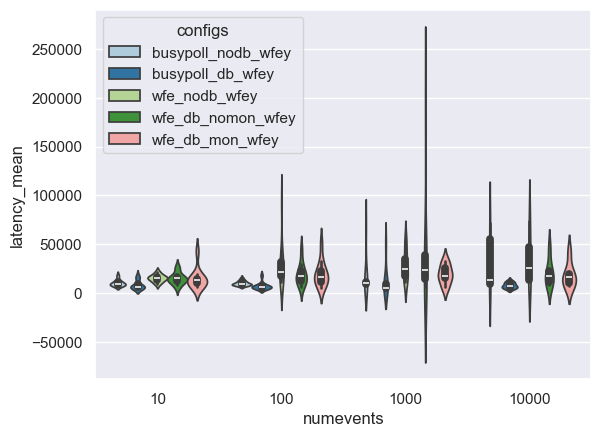

In [25]:
sns.violinplot(data=wfey_no_out, x='numevents', y='latency_mean', hue='configs')
print(wfey_no_out[ ( wfey_no_out['numevents'] == 1000) & (wfey_no_out['configs'] == 'wfe_db_nomon_wfey')].loc[:, ['KEY', 'latency_mean']])

<Axes: xlabel='numevents', ylabel='latency_min'>

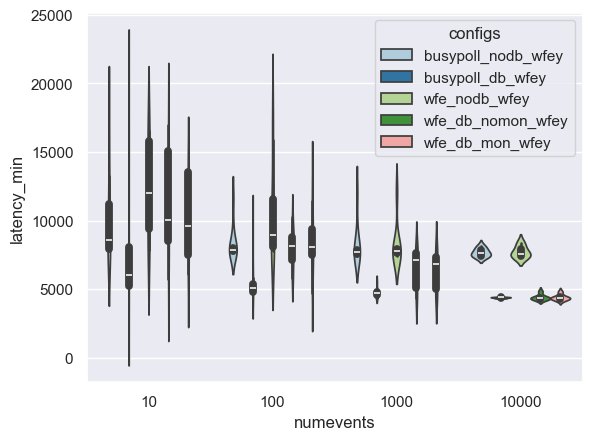

In [15]:
sns.violinplot(data=wfey_no_out, x='numevents', y='latency_min', hue='configs')

<Axes: xlabel='numevents', ylabel='latency_max'>

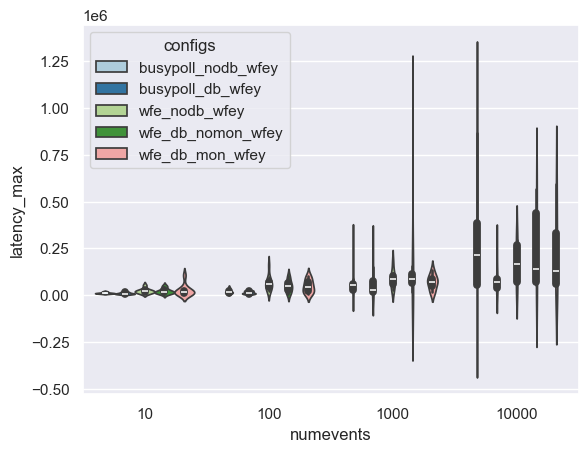

In [16]:
sns.violinplot(data=wfey_no_out, x='numevents', y='latency_max', hue='configs')

##### Min/Max/Mean per Config

10000_0.01_10: AttributeError


/var/folders/_g/p1k71chj0gz6j8jb7c48r03c0000gn/T/ipykernel_43358/2579959063.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

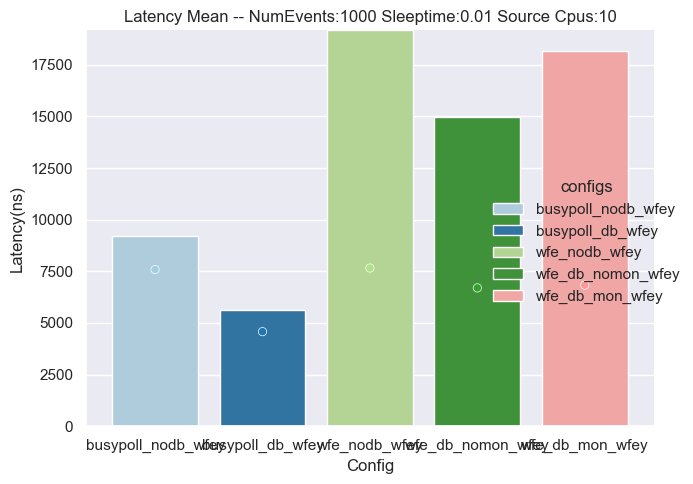

<Figure size 640x480 with 0 Axes>

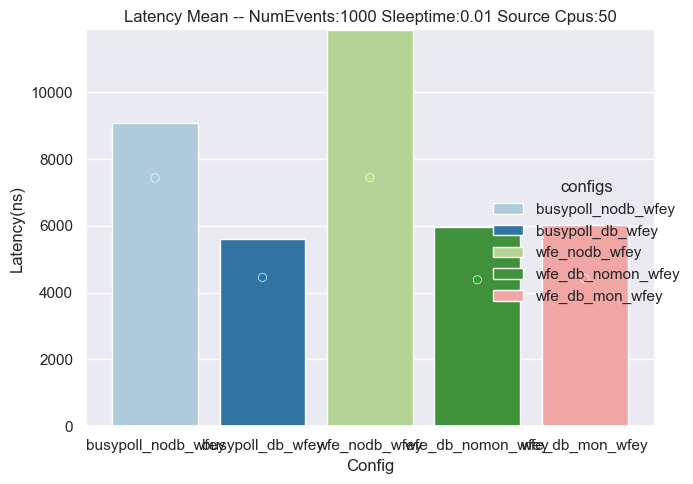

<Figure size 640x480 with 0 Axes>

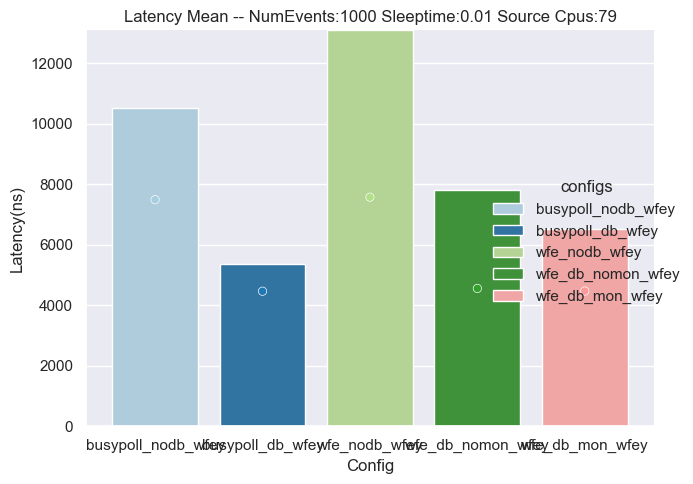

<Figure size 640x480 with 0 Axes>

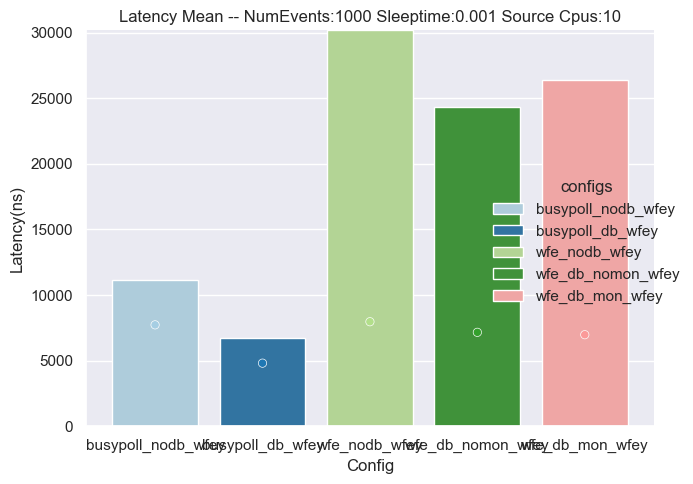

<Figure size 640x480 with 0 Axes>

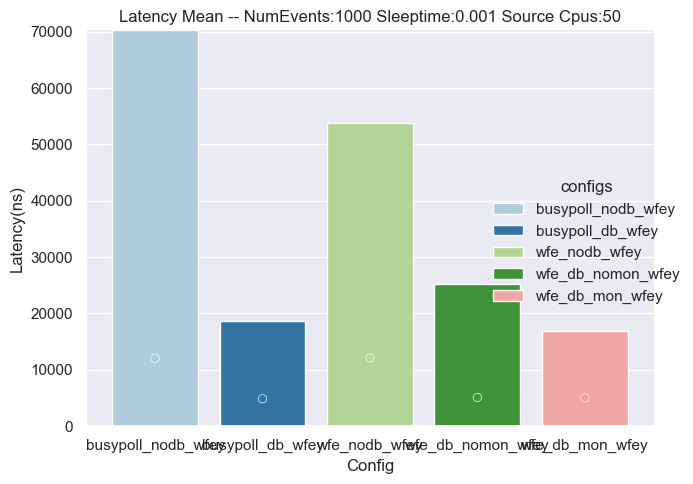

<Figure size 640x480 with 0 Axes>

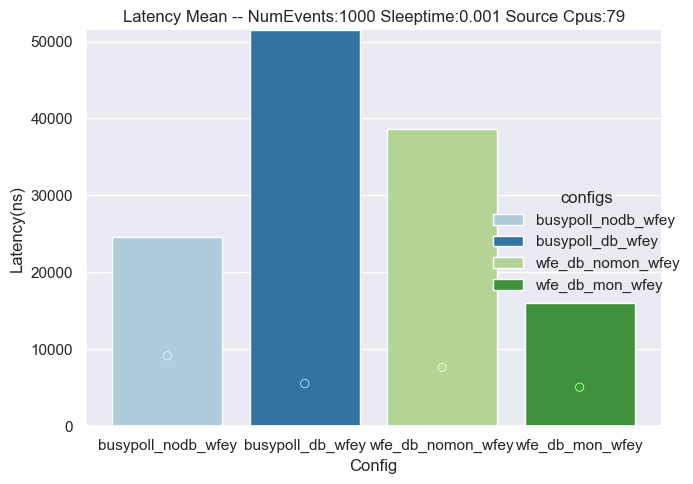

<Figure size 640x480 with 0 Axes>

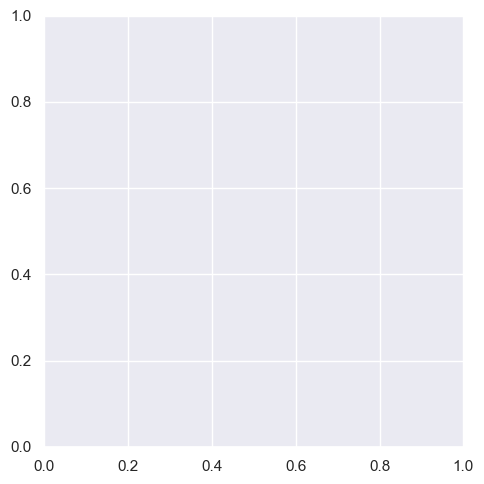

<Figure size 640x480 with 0 Axes>

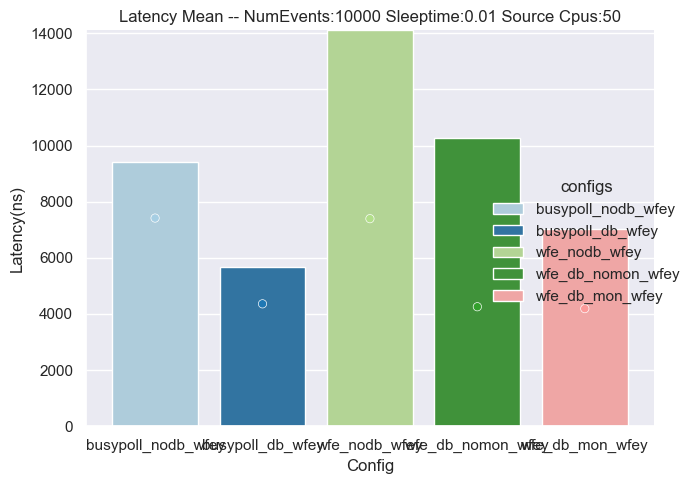

<Figure size 640x480 with 0 Axes>

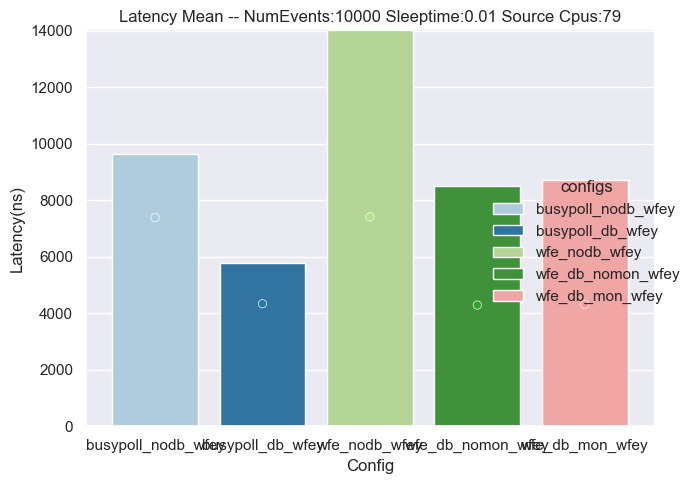

<Figure size 640x480 with 0 Axes>

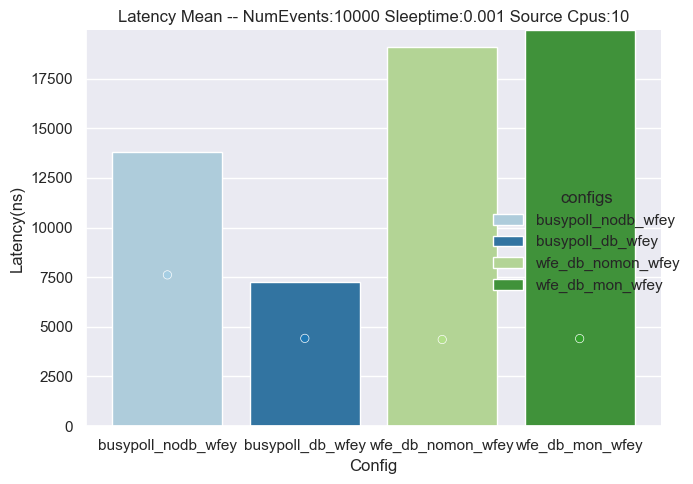

<Figure size 640x480 with 0 Axes>

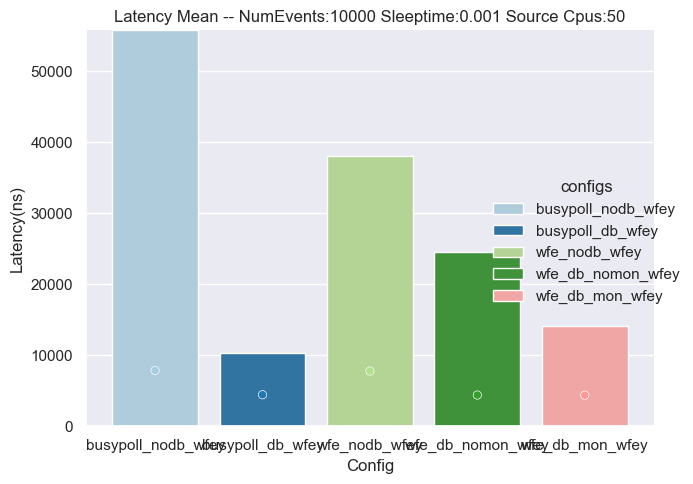

<Figure size 640x480 with 0 Axes>

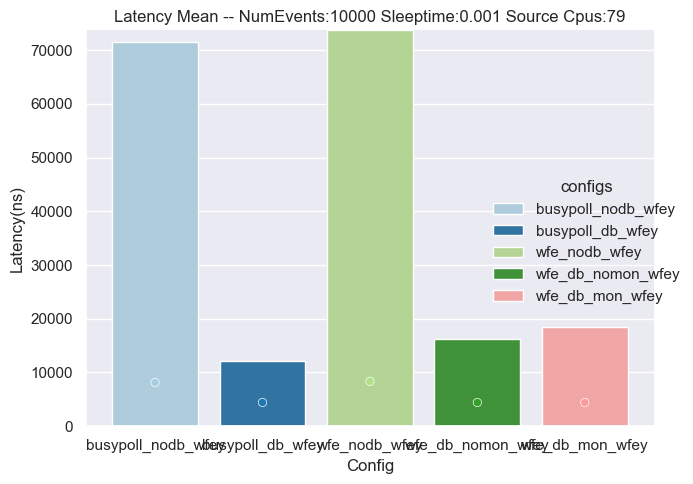

In [17]:
df_used = wfey_no_out

for e in eventsubset:
    for s in sleeptimesubset:
        for sc in sourceCPUsubset:
            plt.figure()
            config_set = df_used[ (df_used['numevents'] == e) &
                                    (df_used['sleeptime'] == s) &
                                    (df_used['sourceCPUs'] == sc)]

            #mean_set = config_set.assign( hwmon2_standard = (config_set['hwmon2'] - config_set['hwmon2'].mean()) / (config_set['hwmon2'].std()) )
            #print(config_set)
            key = str(e)+"_"+str(s)+"_"+str(sc)
            try:
                g = sns.catplot(
                data=config_set, 
                kind="bar",
                x='configs',
                y='latency_mean',
                hue='configs',
                legend=True,
                errorbar=None
                )
            except Exception as exc:
                print(f"{key}: {exc.__class__.__name__}")
                continue

            sns.scatterplot(
            data=config_set,
            x='configs',
            y='latency_min',
            hue='configs',
            legend=False
            )

            #sns.scatterplot(data=config_set, x='configs', y='latency_max', hue='configs', legend=False)

            #g.fig.get_axes()[0].set_yscale('log')

            #plot_errorbars(lambda x: (x.min(), x.max()))
        
            plt.title('Latency Mean -- NumEvents:'+str(e)+' Sleeptime:'+s+' Source Cpus:'+sc)
            plt.xlabel('Config')
            plt.ylabel('Latency(ns)')
            plt.ylim(0,config_set['latency_mean'].max())
            plt.tight_layout()

### HWMON 3

<Axes: xlabel='numevents', ylabel='hwmon3'>

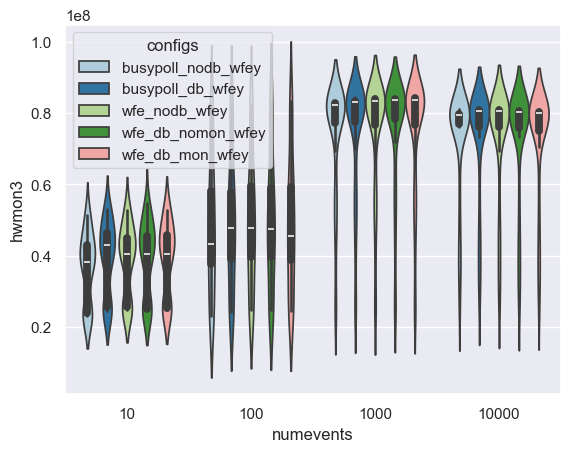

In [18]:
sns.violinplot(data=flat_data, x='numevents', y='hwmon3', hue='configs')